# Explainable AI for Credit Risk Modeling 

#### Note:
I am learning. So I may not be true.

### Explainable AI 
#### Definition: 
AI systems that provide clear, understandable reasons for their decisions.

#### Goal:
Make AI transparent, trustworthy, and accountable for users.

#### Key Methods:
SHAP, LIME, Partial Dependence Plots (PDP), and decision rules.

#### Why Needed?
Ensures compliance, fairness, and user trust in AI predictions.

Example: Explaining why a loan application was approved/rejected.

### Stacked Model
#### Definition:
Advanced ensemble method combining multiple models (base learners) via a meta-learner for better predictions.

#### Process:
Base models make predictions → Meta-model learns optimal combination.

#### Advantage:
Boosts accuracy by leveraging diverse model strengths.

#### Use Case:
Ideal for credit risk to improve reliability over single models.

### RandomizedSearchCV
#### Definition:
Hyperparameter tuning method that randomly samples parameter combinations from defined ranges.

#### Advantage:
Faster than GridSearchCV while still improving model performance.

#### Key Feature:
Uses n_iter to control number of parameter combinations tested.



### XGBoost

#### Definition:
XGBoost is a powerful, scalable machine learning algorithm based on gradient-boosted decision trees, optimized for speed and accuracy.

#### Key Strength:
Handles complex patterns in data while preventing overfitting through built-in regularization.

#### Use Case:
Dominates structured data tasks like credit risk prediction, fraud detection, and competitions (e.g., Kaggle).

#### Advantage:
Combines high performance with interpretability via feature importance scores and SHAP/LIME integration.

### Pipeline

#### Definition:
A scikit-learn Pipeline chains multiple data processing and modeling steps into a single workflow.

#### Purpose: 
Ensures clean separation between training/test data by preventing leakage (e.g., scaling fitted only on training data).

### Loading necessary Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_predict
)
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder,
    QuantileTransformer, KBinsDiscretizer
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import (
    SelectKBest, f_classif, RFECV,
    SelectFromModel, mutual_info_classif
)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    AdaBoostClassifier, StackingClassifier
)
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score,
    brier_score_loss, log_loss
)
from sklearn.inspection import (
    partial_dependence,
    permutation_importance,
    PartialDependenceDisplay
)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import DescrStatsW
import statsmodels.api as sm
import statsmodels.formula.api as smf

import shap
import dalex as dx

import lime
import lime.lime_tabular

from alibi.explainers import ALE, plot_ale

import eli5
from eli5.sklearn import PermutationImportance

from pdpbox import pdp, info_plots

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.ensemble import BalancedRandomForestClassifier

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import pingouin as pg


In [2]:
np.random.seed(123)

In [3]:
# Set matplotlib style
plt.style.use('seaborn-v0_8')
%matplotlib inline

In [4]:
df= pd.read_csv('credit_risk_dataset.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4

In [5]:
df.describe()

person_age  person_income  person_emp_length     loan_amnt  \
count  32581.000000   3.258100e+04       31686.000000  32581.000000   
mean      27.734600   6.607485e+04           4.789686   9589.371106   
std        6.348078   6.198312e+04           4.142630   6322.086646   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.850000e+04           2.000000   5000.000000   
50%       26.000000   5.500000e+04           4.000000   8000.000000   
75%       30.000000   7.920000e+04           7.000000  12200.000000   
max      144.000000   6.000000e+06         123.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   29465.000000  32581.000000         32581.000000   
mean       11.011695      0.218164             0.170203   
std         3.240459      0.413006             0.106782   
min         5.420000      0.000000             0.000000   
25%         7.900000      0.000000             0.090000   
50%        10.990000      0.000000             0.150000   
75%        13.470000      0.000000             0.230000   
max        23.220000      1.000000             0.830000   

       cb_person_cred_hist_length  
count                32581.000000  
mean                     5.804211  
std                      4.055001  
min                      2.000000  
25%                      3.000000  
50%                      4.000000  
75%                      8.000000  
max                     30.000000

## Data PreProcessing

In [6]:
def preprocess_data(df):
    print("\nPerforming data preprocessing...")
    
    # Create copy to preserve original data
    df_clean = df.copy()
    
    # 1. Missing value analysis
    print("\nMissing values analysis:")
    missing = df_clean.isnull().sum()
    missing_pct = (missing / len(df_clean)) * 100
    missing_analysis = pd.concat([missing, missing_pct], axis=1)
    missing_analysis.columns = ['Missing Count', 'Missing %']
    display(missing_analysis.sort_values('Missing %', ascending=False))
    
    # 2. Handle missing values
    num_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = df_clean.select_dtypes(include=['object']).columns
    
    # Numerical features
    for col in num_cols:
        if df_clean[col].isnull().sum() > 0:
            if abs(df_clean[col].skew()) > 1:
                df_clean[col].fillna(df_clean[col].median(), inplace=True)
            else:
                df_clean[col].fillna(df_clean[col].mean(), inplace=True)
    
    # Categorical features
    for col in cat_cols:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col].fillna('Missing', inplace=True)
    
    # 3. Outlier treatment
    print("\nOutlier analysis:")
    outlier_report = pd.DataFrame(columns=['Feature', 'Outliers Count', 'Outliers %', 'Treatment'])
    
    for col in num_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
        outlier_pct = (len(outliers) / len(df_clean)) * 100
        
        if outlier_pct < 5:
            df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
            df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])
            treatment = 'Winsorized'
        else:
            treatment = 'Retained (too many outliers)'
        
        new_row = pd.DataFrame({
            'Feature': [col],
            'Outliers Count': [len(outliers)],
            'Outliers %': [outlier_pct],
            'Treatment': [treatment]
        })
        
        outlier_report = pd.concat([outlier_report, new_row], ignore_index=True)
    
    display(outlier_report)
    
    # 4. Feature type conversion
    binary_cols = [col for col in cat_cols if df_clean[col].nunique() == 2]
    for col in binary_cols:
        df_clean[col] = df_clean[col].astype('category').cat.codes
    
    yn_cols = [col for col in df_clean.columns if set(df_clean[col].unique()).issubset({'Y', 'N'})]
    for col in yn_cols:
        df_clean[col] = (df_clean[col] == 'Y').astype(int)
    
    print("\nData after preprocessing:")
    display(df_clean.head())
    
    return df_clean

# Then preprocess your data
df = preprocess_data(df)



Performing data preprocessing...

Missing values analysis:


Missing Count  Missing %
loan_int_rate                        3116   9.563856
person_emp_length                     895   2.747000
person_age                              0   0.000000
person_income                           0   0.000000
person_home_ownership                   0   0.000000
loan_intent                             0   0.000000
loan_grade                              0   0.000000
loan_amnt                               0   0.000000
loan_status                             0   0.000000
loan_percent_income                     0   0.000000
cb_person_default_on_file               0   0.000000
cb_person_cred_hist_length              0   0.000000


Outlier analysis:


Feature Outliers Count  Outliers %  \
0                  person_age            249    0.764249   
1               person_income            433    1.328995   
2           person_emp_length             54    0.165741   
3                   loan_amnt            192    0.589301   
4               loan_int_rate              0    0.000000   
5                 loan_status           7108   21.816396   
6         loan_percent_income             23    0.070593   
7  cb_person_cred_hist_length            149    0.457322   

                      Treatment  
0                    Winsorized  
1                    Winsorized  
2                    Winsorized  
3                    Winsorized  
4                    Winsorized  
5  Retained (too many outliers)  
6                    Winsorized  
7                    Winsorized


Data after preprocessing:


person_age  person_income person_home_ownership  person_emp_length  \
0        22.0        59000.0                  RENT               22.0   
1        21.0         9600.0                   OWN                5.0   
2        25.0         9600.0              MORTGAGE                1.0   
3        23.0        65500.0                  RENT                4.0   
4        24.0        54400.0                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D    33800.0          16.02            1   
1   EDUCATION          B     1000.0          11.14            0   
2     MEDICAL          C     5500.0          12.87            1   
3     MEDICAL          C    33800.0          15.23            1   
4     MEDICAL          C    33800.0          14.27            1   

   loan_percent_income  cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                          1                         3.0  
1                 0.10                          0                         2.0  
2                 0.57                          0                         3.0  
3                 0.53                          0                         2.0  
4                 0.55                          1                         4.0

### Features Engineering

In [7]:
def feature_engineering(df):
    print("\nPerforming feature engineering...")

    original_cols = df.columns.tolist()
    
    # 1. Financial ratios
    df['debt_to_income'] = df['loan_amnt'] / (df['person_income'] + 1e-6)
    df['income_to_loan_ratio'] = df['person_income'] / (df['loan_amnt'] + 1e-6)
    df['interest_to_income'] = (df['loan_amnt'] * df['loan_int_rate'] / 100) / (df['person_income'] + 1e-6)
    df['employment_to_age_ratio'] = df['person_emp_length'] / (df['person_age'] + 1e-6)
    
    # 2. bucketing Features
    df['age_cohort'] = pd.cut(df['person_age'],
                             bins=[0, 25, 35, 45, 55, 65, 100],
                             labels=['GenZ', 'Millennial', 'GenX', 'Boomer', 'Silent', 'Greatest'])
    
    df['income_quantile'] = pd.qcut(df['person_income'],
                                  q=5,
                                  labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
    
    # 3. Interaction terms
    df['high_risk_age_income'] = ((df['person_age'] < 25) & (df['person_income'] < 50000)).astype(int)
    df['low_income_high_debt'] = ((df['person_income'] < df['person_income'].median()) & 
                                (df['loan_percent_income'] > 0.4)).astype(int)
    
    # 4. financial features
    df['loan_to_value_ratio'] = df['loan_amnt'] / (df['person_income'] * 5)
    df['affordability_index'] = (df['person_income'] / 12) / (df['loan_amnt'] * df['loan_int_rate'] / 1200 + 1e-6)
    
    # 5. Risk score calculations
    df['emp_length_score'] = np.where(df['person_emp_length'] > 5, 1, 0)
    df['credit_hist_score'] = np.where(df['cb_person_cred_hist_length'] > 3, 1, 0)
    df['simple_risk_score'] = df['emp_length_score'] + df['credit_hist_score']
    
    # Show new features
    new_features = list(set(df.columns) - set(original_cols))
    print("\nAdded features:")
    print(sorted(new_features))

    return df

# Perform feature engineering
df = feature_engineering(df)



Performing feature engineering...

Added features:
['affordability_index', 'age_cohort', 'credit_hist_score', 'debt_to_income', 'emp_length_score', 'employment_to_age_ratio', 'high_risk_age_income', 'income_quantile', 'income_to_loan_ratio', 'interest_to_income', 'loan_to_value_ratio', 'low_income_high_debt', 'simple_risk_score']


## Exploratory Data Analysis 


Performing EDA...


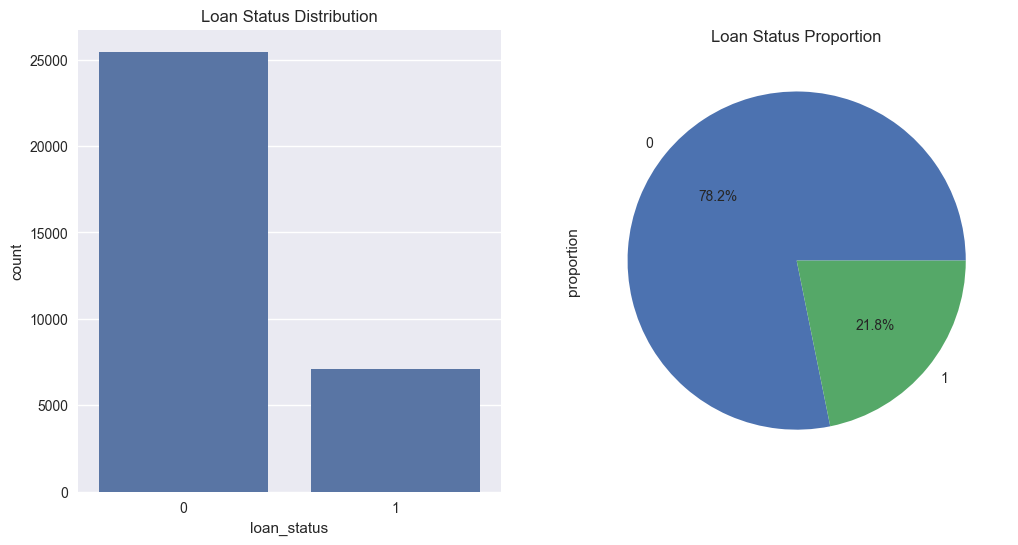


Default rate: 21.82% (95% CI: 21.37%-22.27%)

Numerical features analysis:


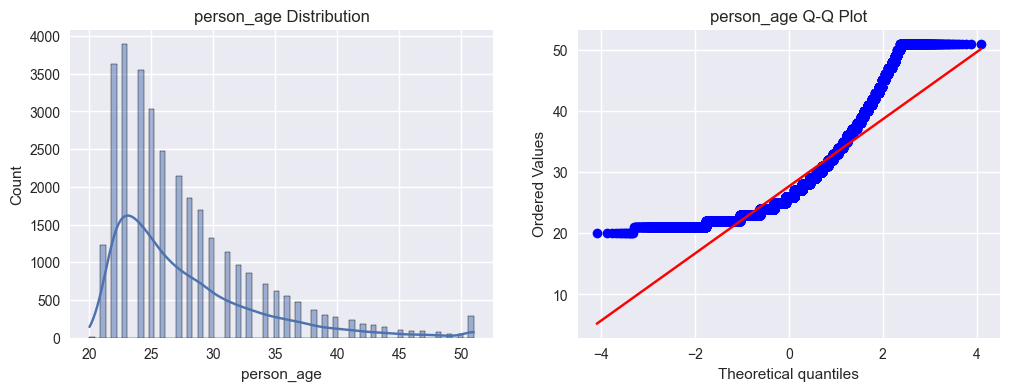

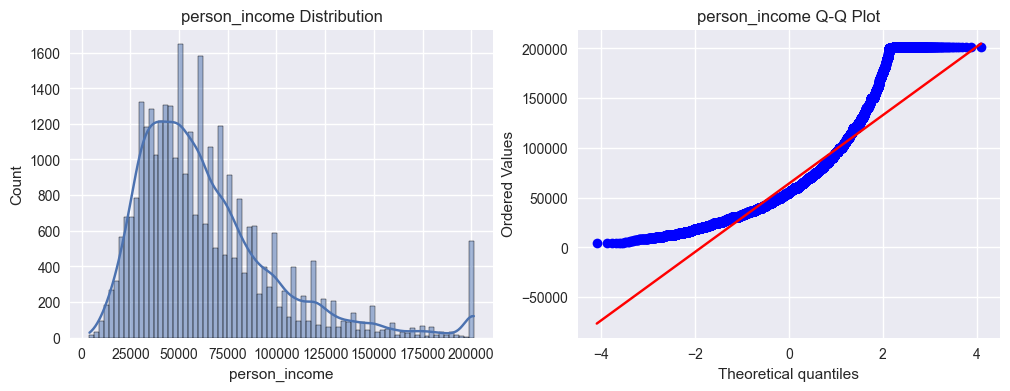

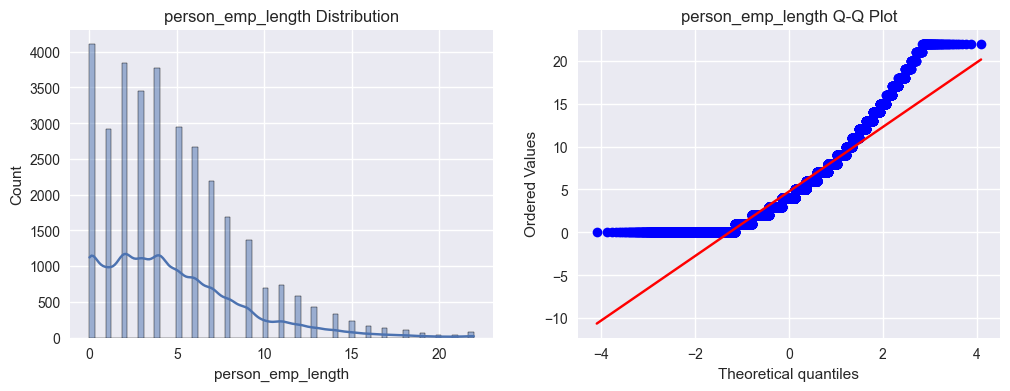

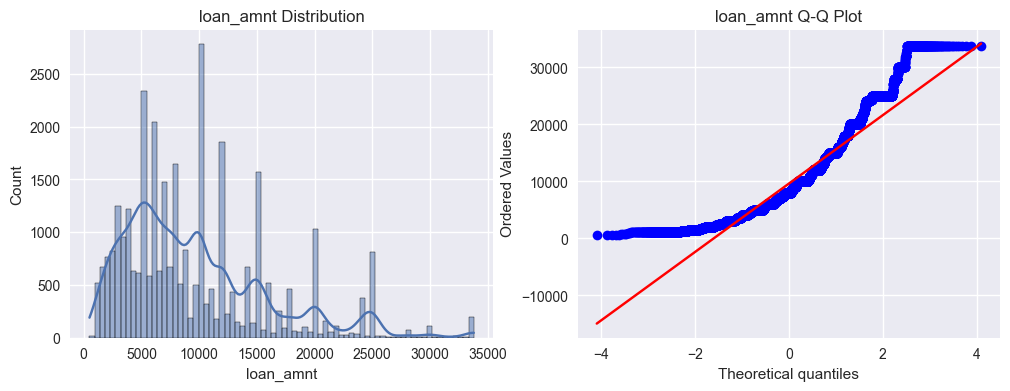

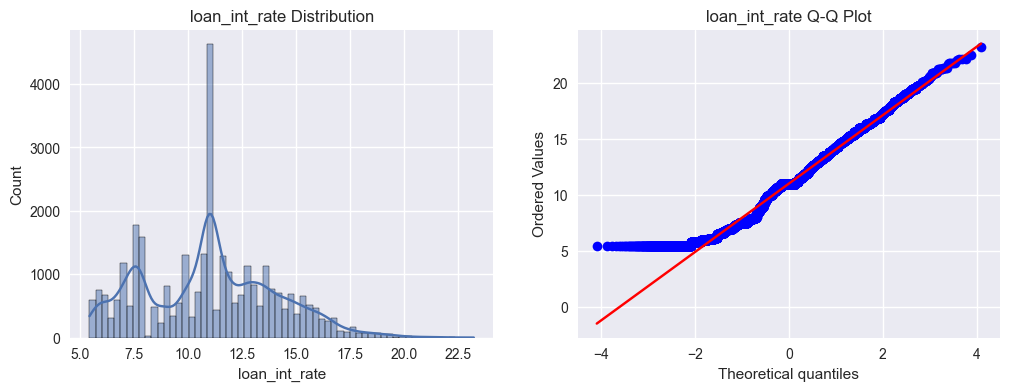

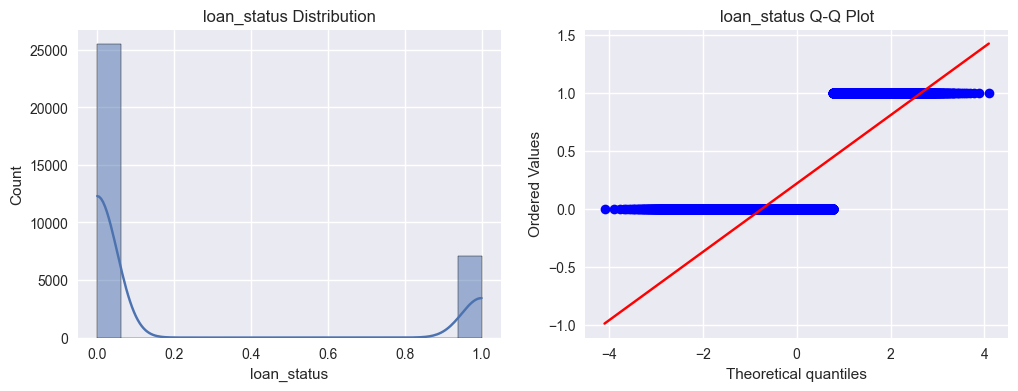

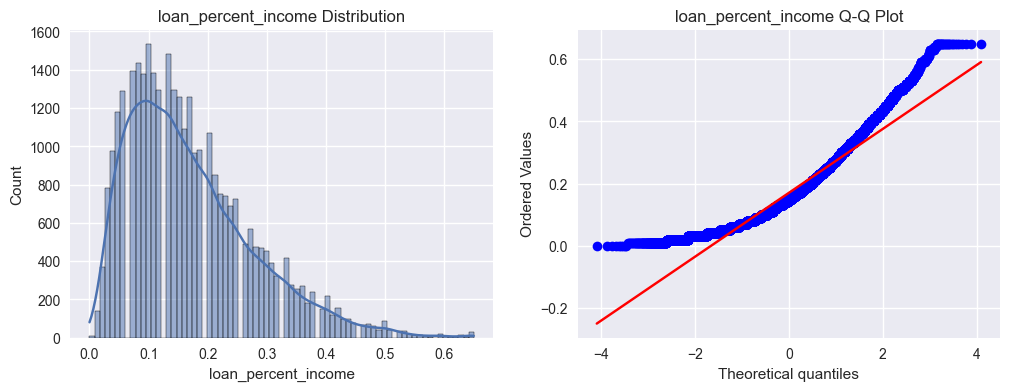

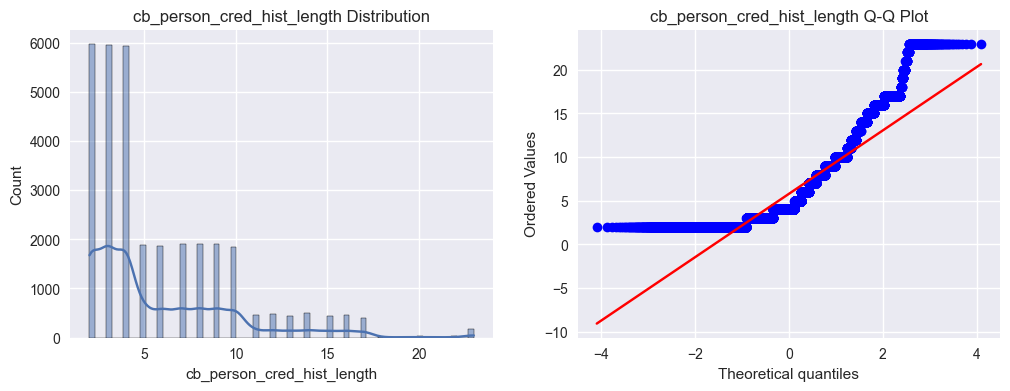

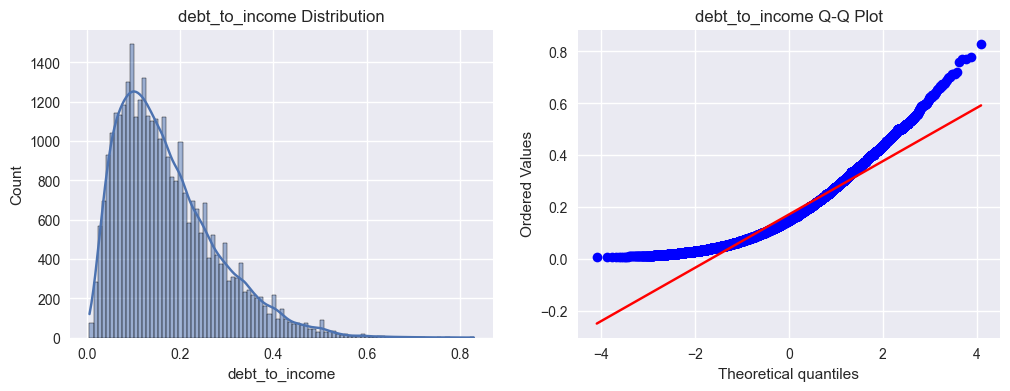

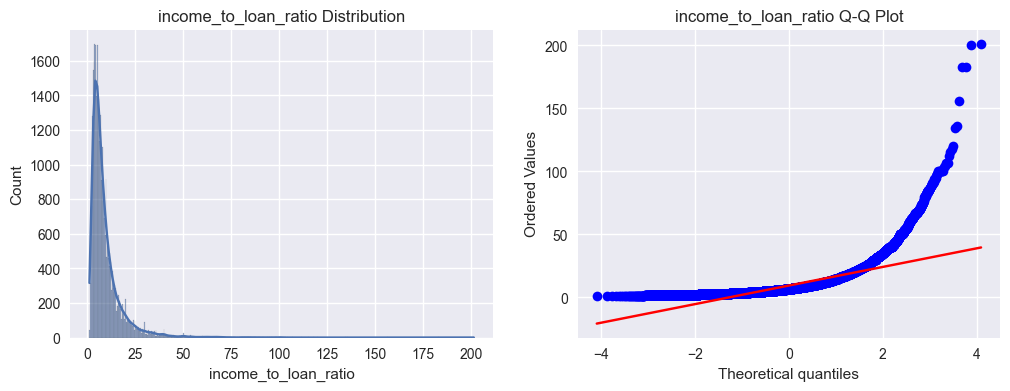

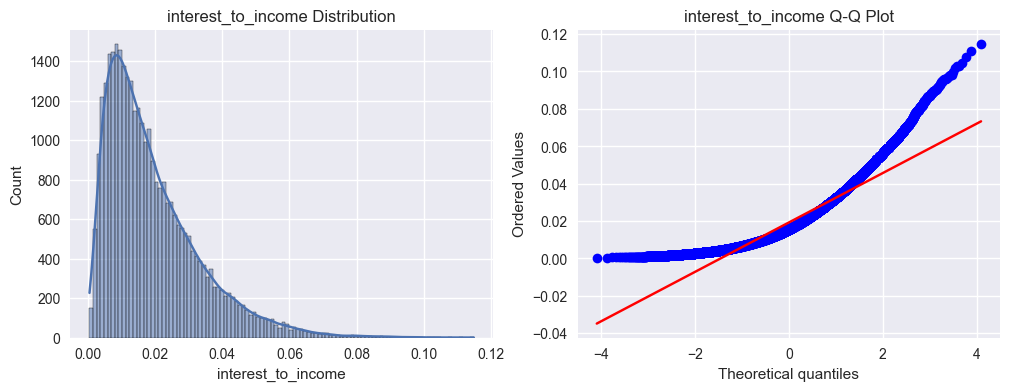

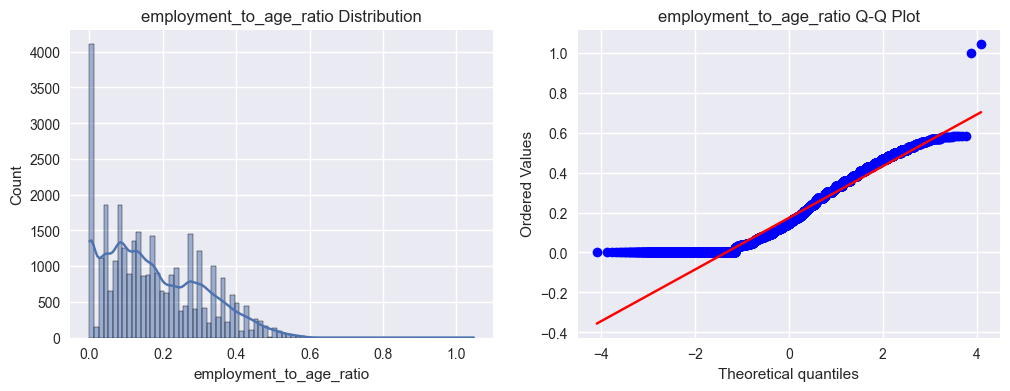

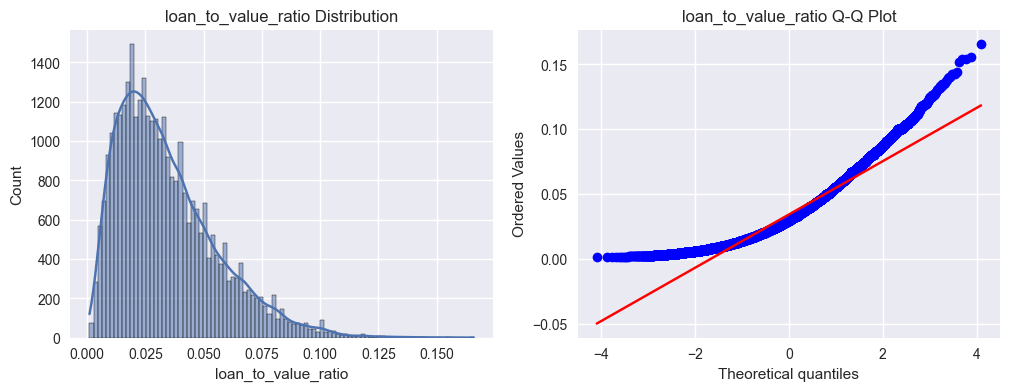

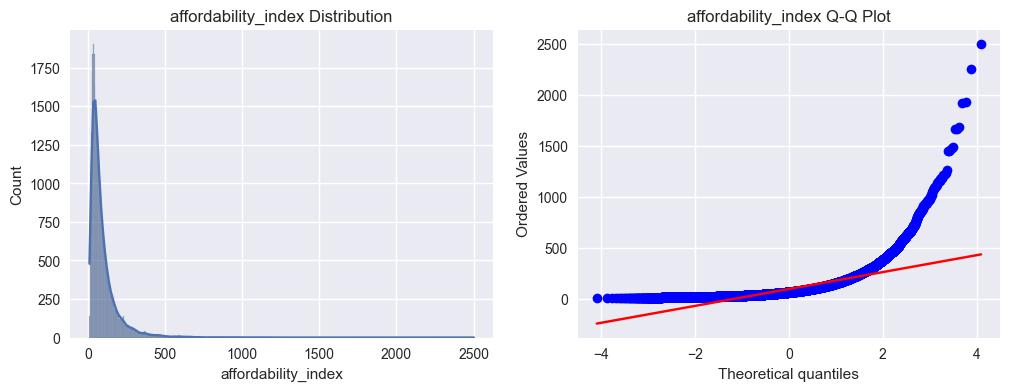

Mean     Median      Skew   Kurtosis  \
person_age                     27.668273       26.0  1.541114   2.487979   
person_income               64048.879715    55000.0  1.512419   2.732792   
person_emp_length               4.754826        4.0  1.168185   1.638411   
loan_amnt                    9582.492864     8000.0  1.160274   1.237463   
loan_int_rate                  11.011695  11.011695    0.2193  -0.425356   
loan_status                     0.218164        0.0  1.364888  -0.137088   
loan_percent_income             0.170163       0.15  1.043781   1.070593   
cb_person_cred_hist_length      5.786563        4.0  1.455619   2.125487   
debt_to_income                  0.170816   0.148368  1.068778   1.223322   
income_to_loan_ratio            9.491955       6.74  4.591322  41.967428   
interest_to_income              0.019205   0.015552  1.429783   2.647967   
employment_to_age_ratio         0.173456   0.148148  0.585288  -0.446723   
loan_to_value_ratio             0.034163   0.029674  1.068778   1.223322   
affordability_index            96.252349  64.300865  4.863785  46.380546   

                           Normality (p-value)  
person_age                                 NaN  
person_income                              NaN  
person_emp_length                          NaN  
loan_amnt                                  NaN  
loan_int_rate                              NaN  
loan_status                                NaN  
loan_percent_income                        NaN  
cb_person_cred_hist_length                 NaN  
debt_to_income                             NaN  
income_to_loan_ratio                       NaN  
interest_to_income                         NaN  
employment_to_age_ratio                    NaN  
loan_to_value_ratio                        NaN  
affordability_index                        NaN


Correlation matrix:


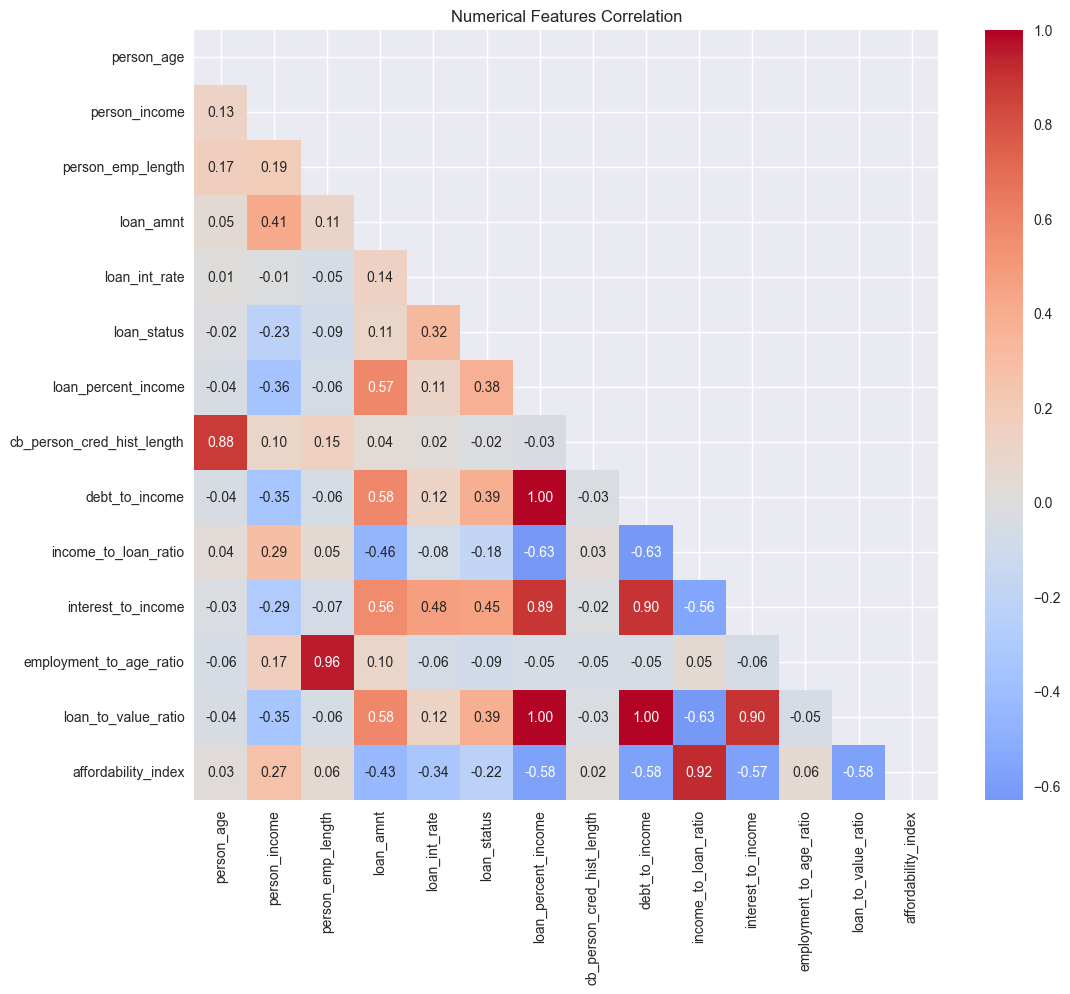


Categorical features analysis:


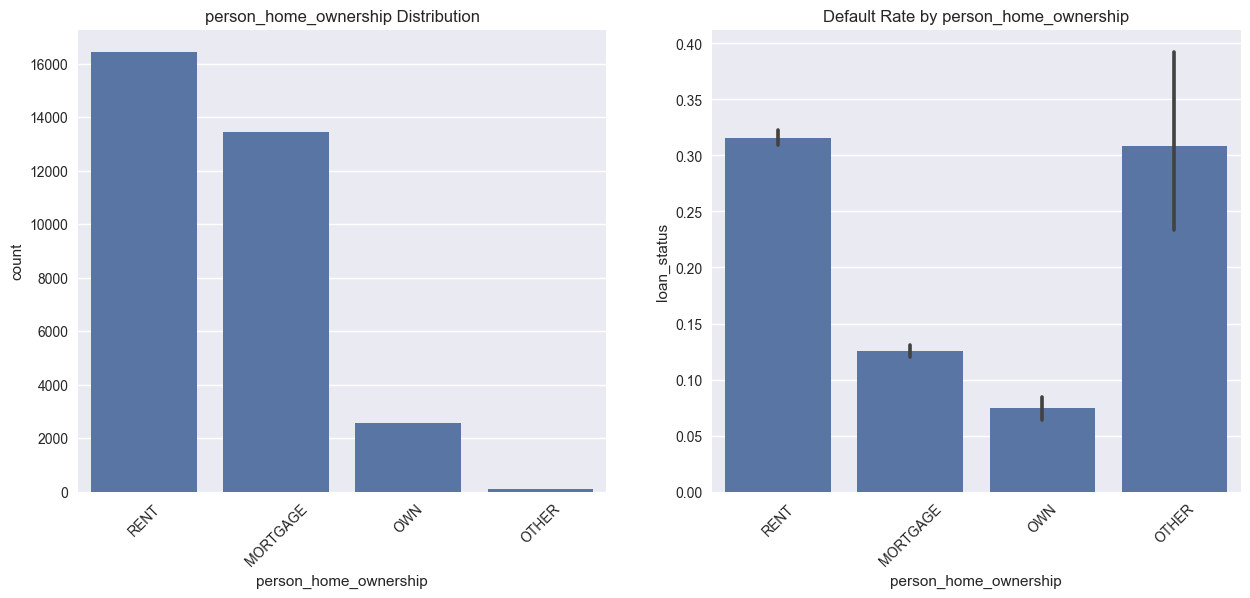


person_home_ownership vs. loan_status: Chi2=1907.98, p=0.0000, df=3


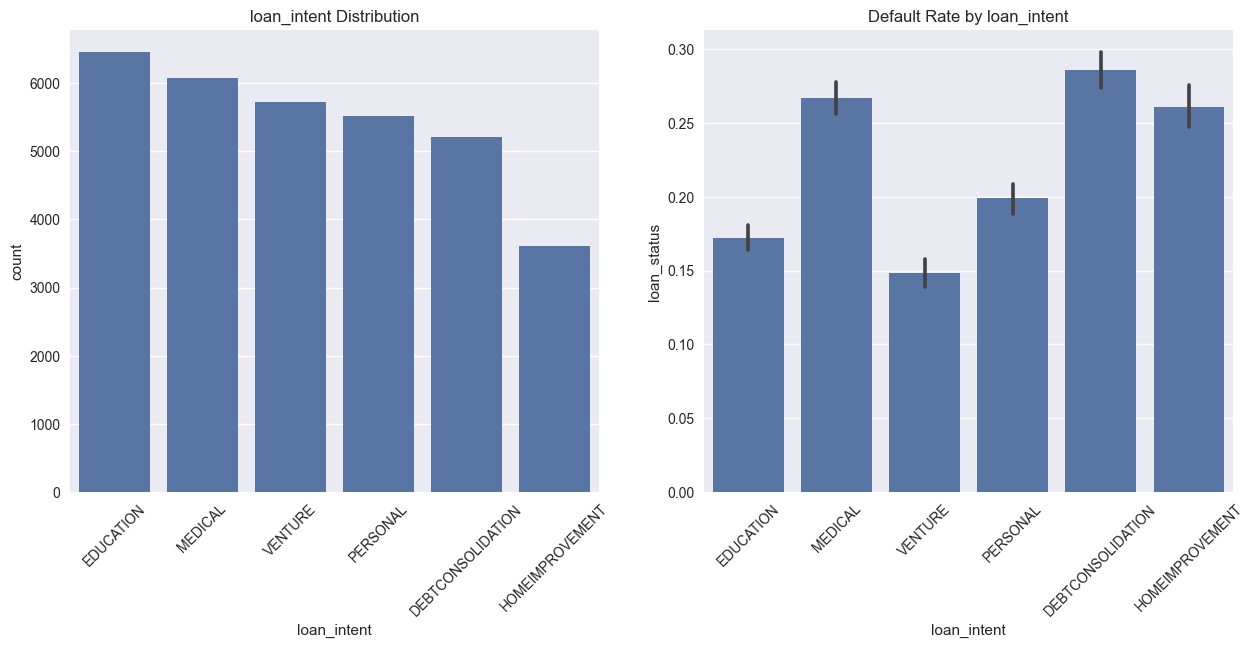


loan_intent vs. loan_status: Chi2=520.51, p=0.0000, df=5


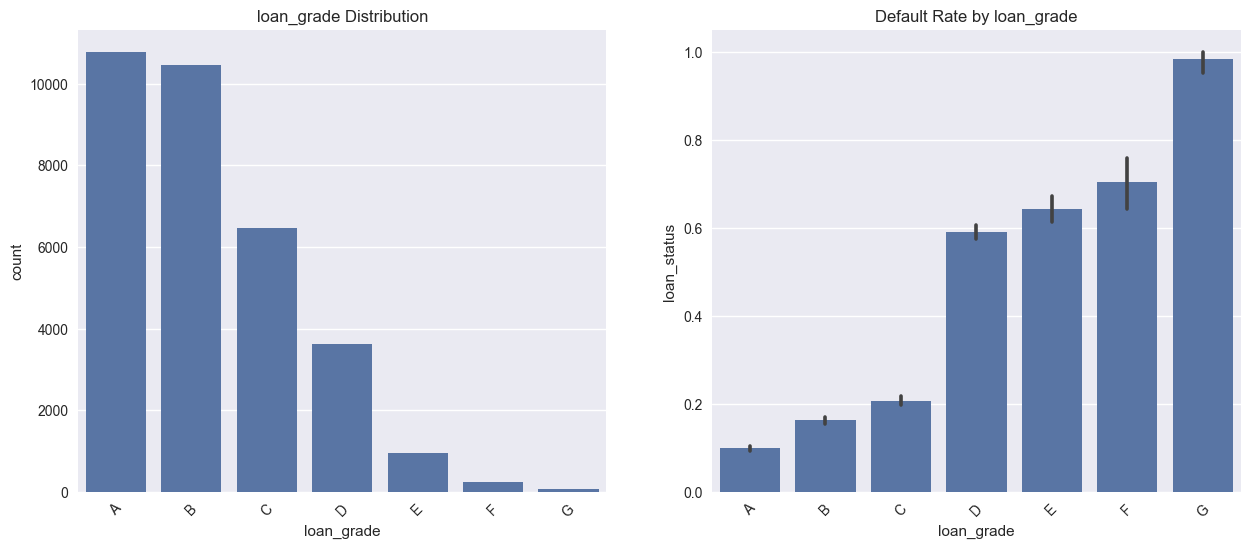


loan_grade vs. loan_status: Chi2=5609.18, p=0.0000, df=6


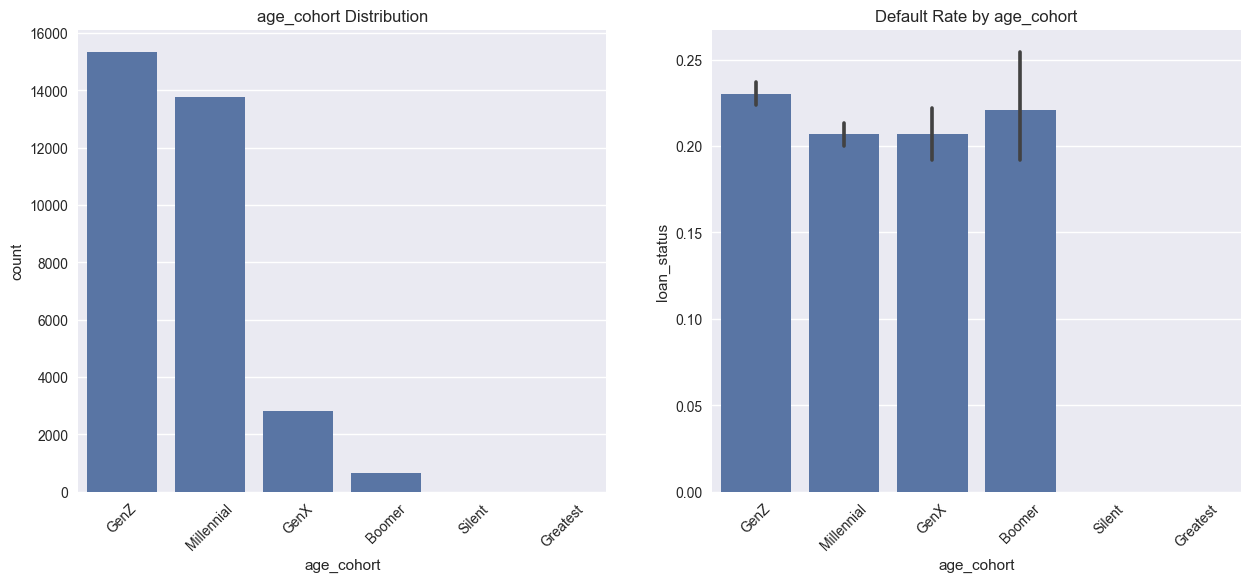


age_cohort vs. loan_status: Chi2=25.64, p=0.0000, df=3


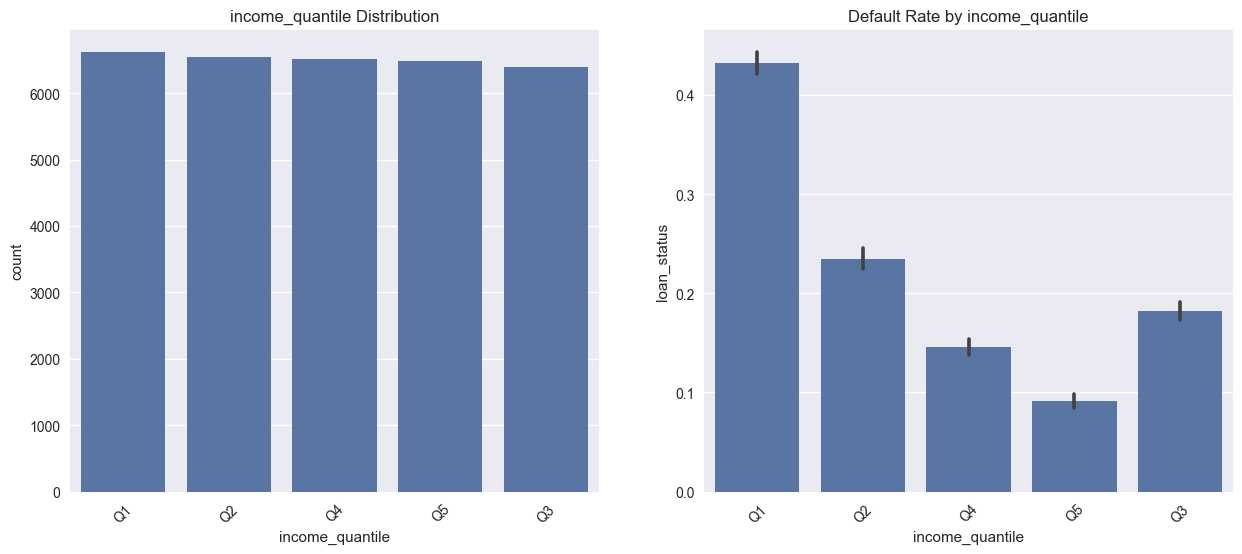


income_quantile vs. loan_status: Chi2=2660.40, p=0.0000, df=4

Target vs. features analysis:


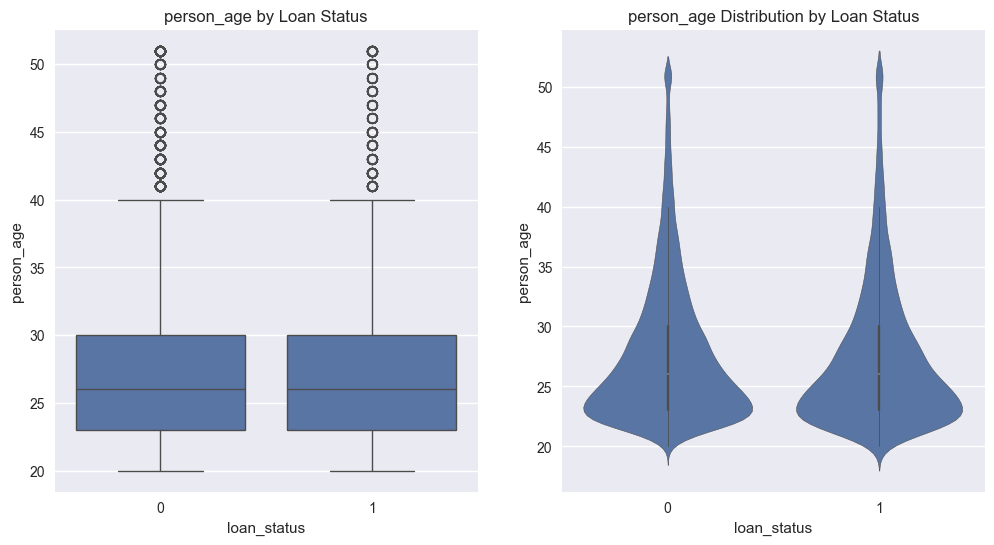

person_age: t=4.01, p=0.0001 (Welch's t-test)


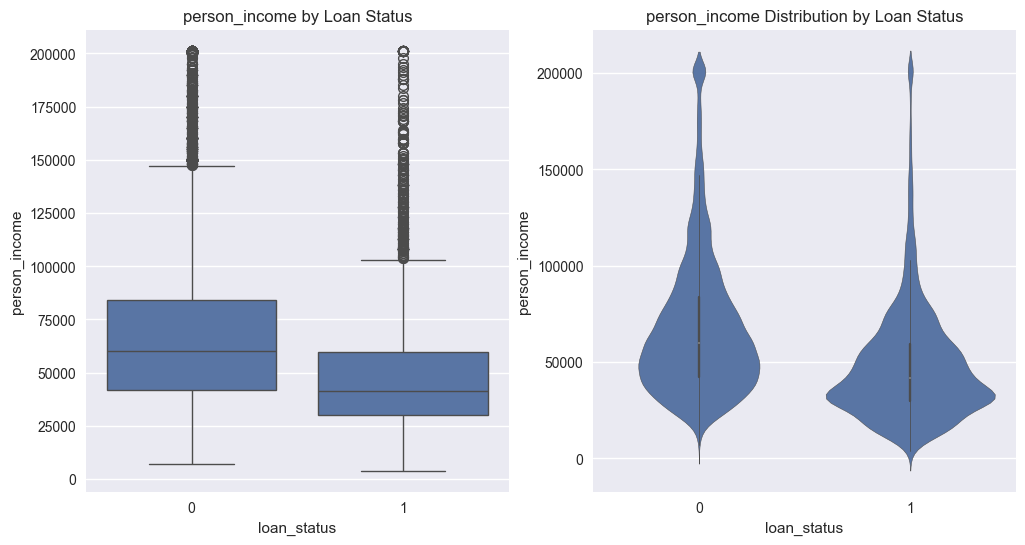

person_income: t=46.91, p=0.0000 (Welch's t-test)


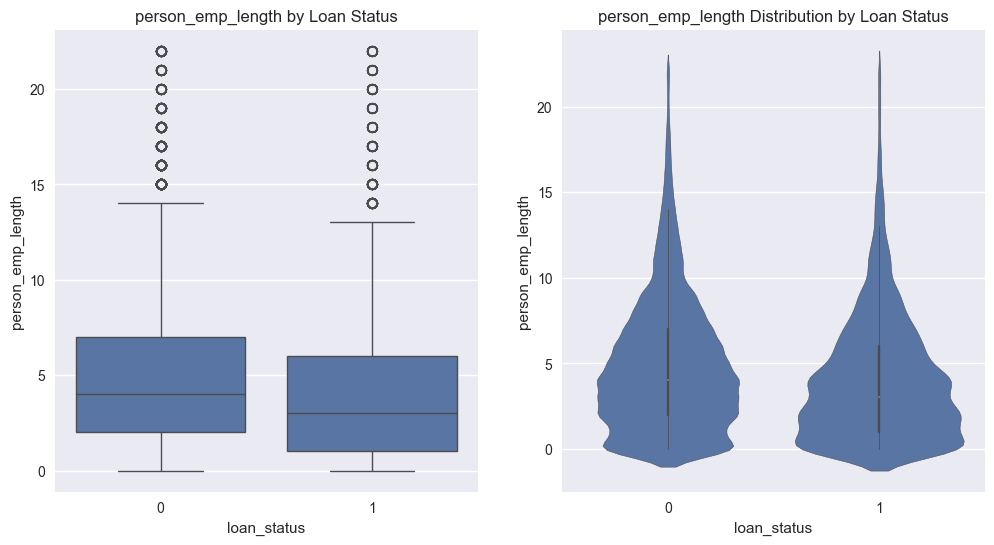

person_emp_length: t=16.10, p=0.0000 (Welch's t-test)


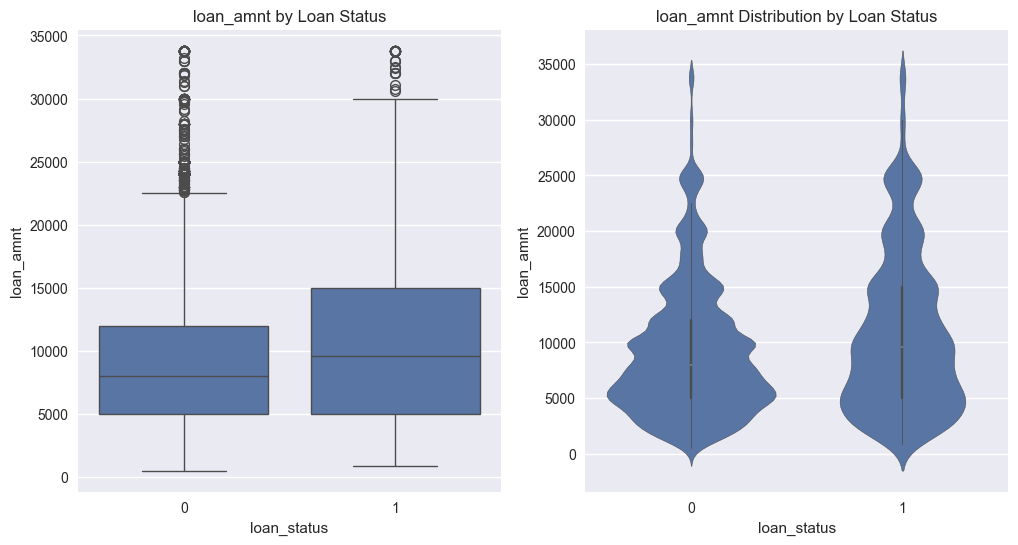

loan_amnt: t=-17.42, p=0.0000 (Welch's t-test)


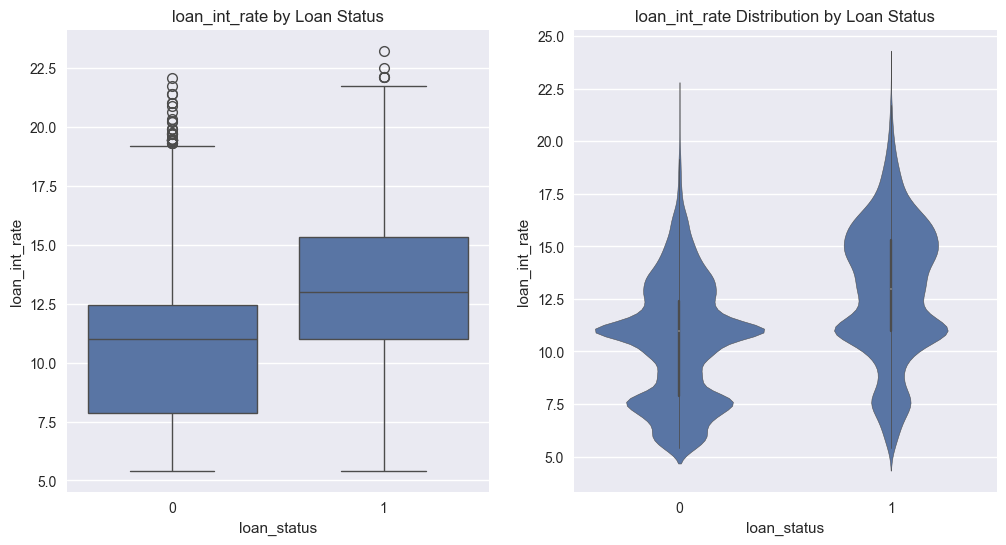

loan_int_rate: t=-56.92, p=0.0000 (Welch's t-test)


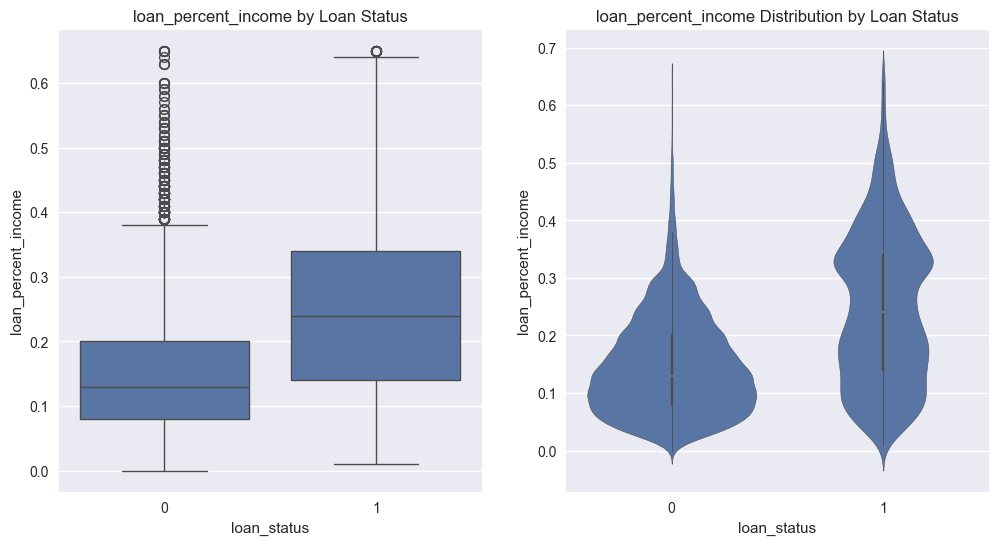

loan_percent_income: t=-59.20, p=0.0000 (Welch's t-test)


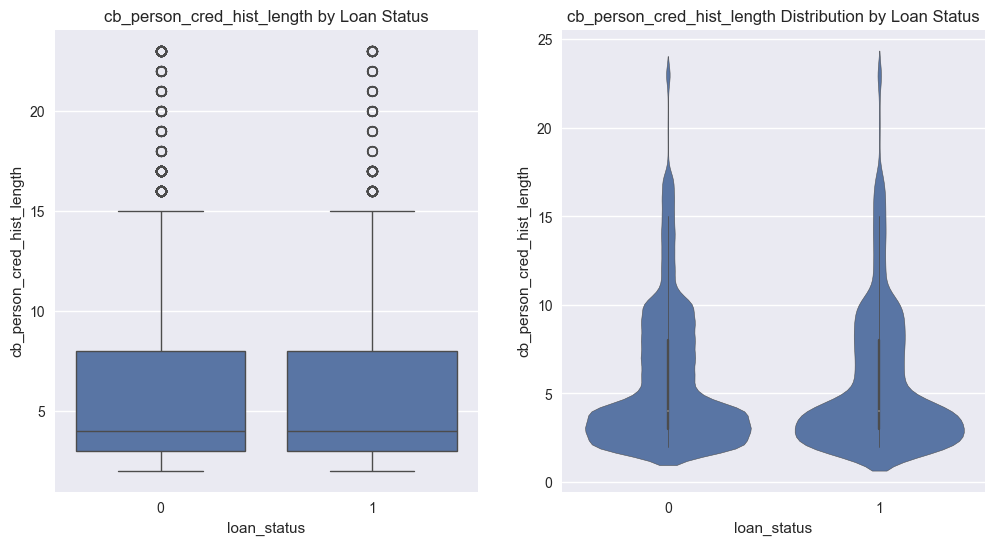

cb_person_cred_hist_length: t=2.99, p=0.0028 (Welch's t-test)


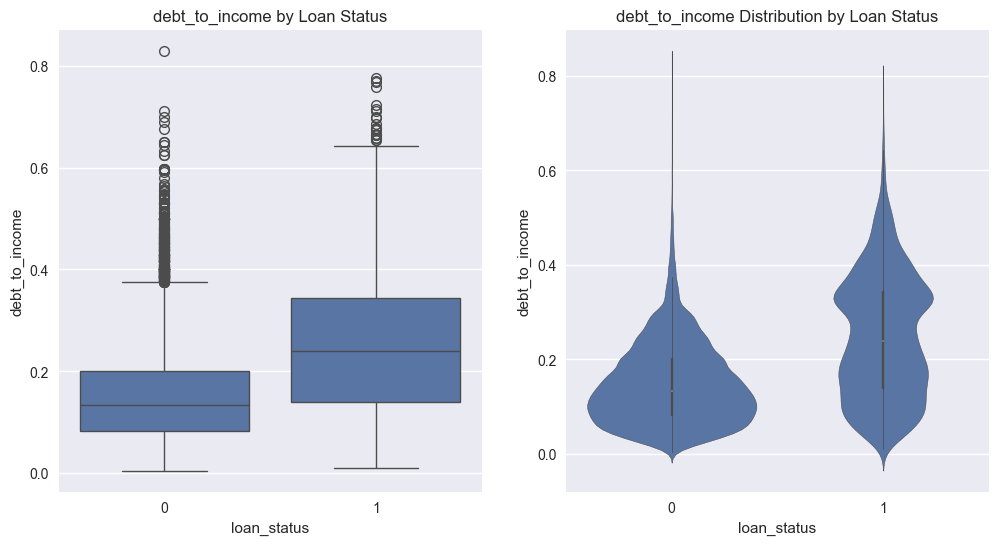

debt_to_income: t=-60.30, p=0.0000 (Welch's t-test)


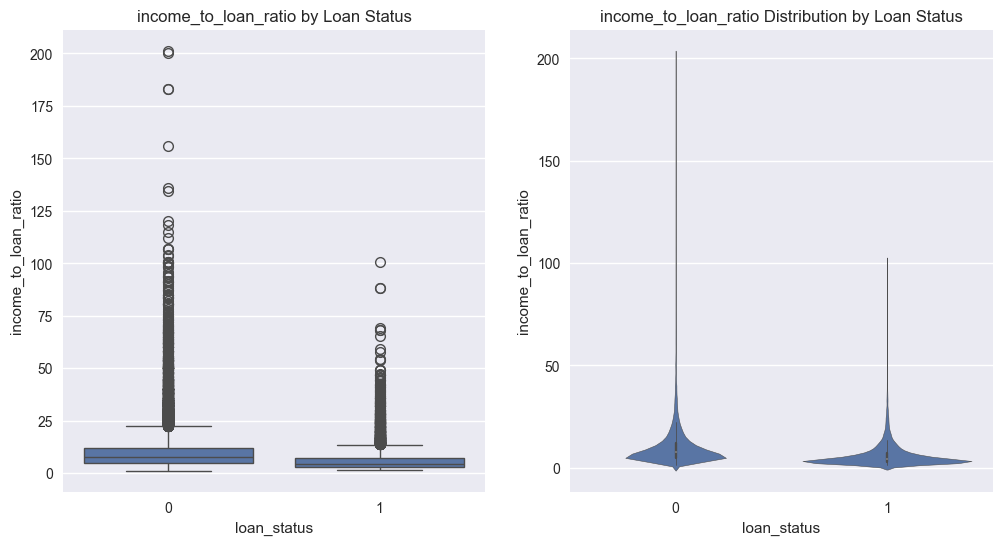

income_to_loan_ratio: t=41.87, p=0.0000 (Welch's t-test)


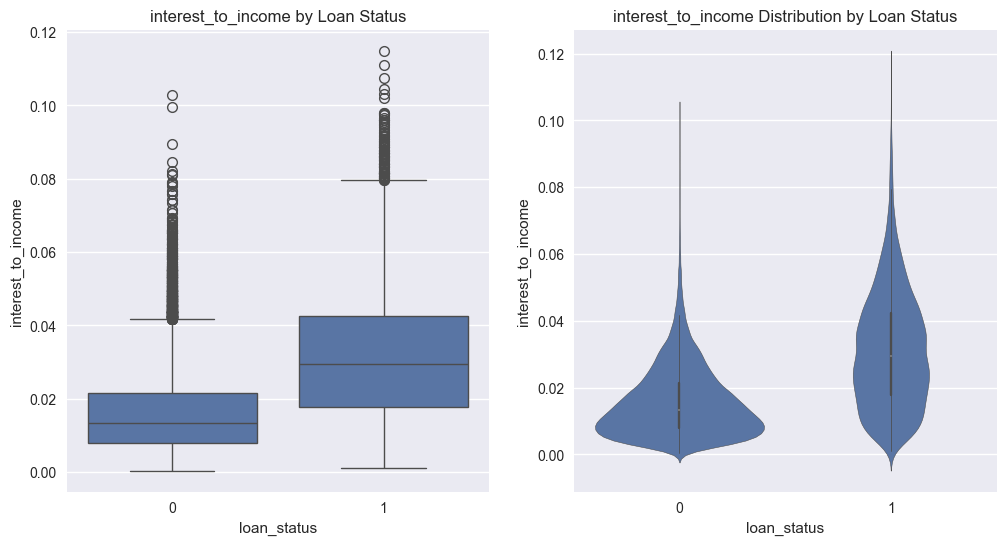

interest_to_income: t=-70.66, p=0.0000 (Welch's t-test)


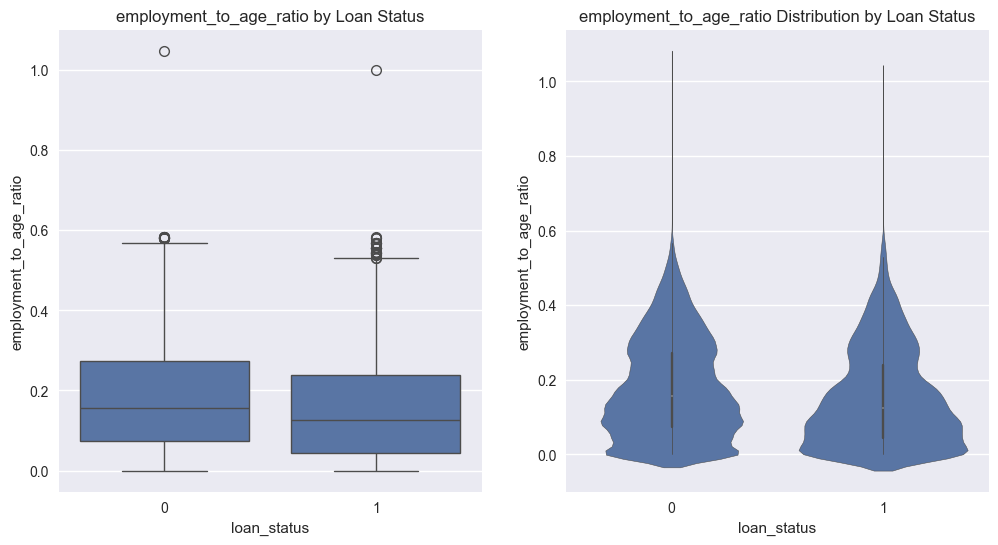

employment_to_age_ratio: t=15.78, p=0.0000 (Welch's t-test)


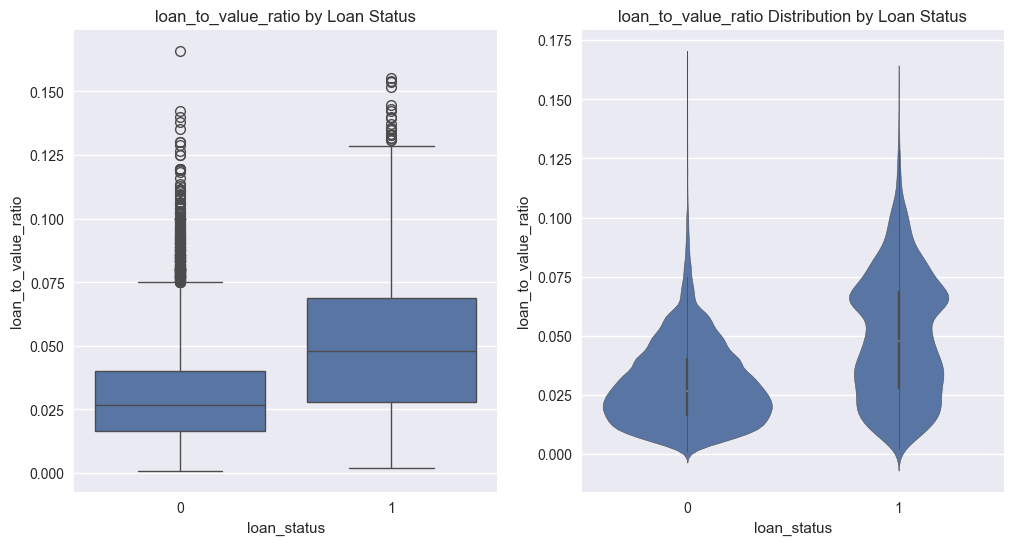

loan_to_value_ratio: t=-60.30, p=0.0000 (Welch's t-test)


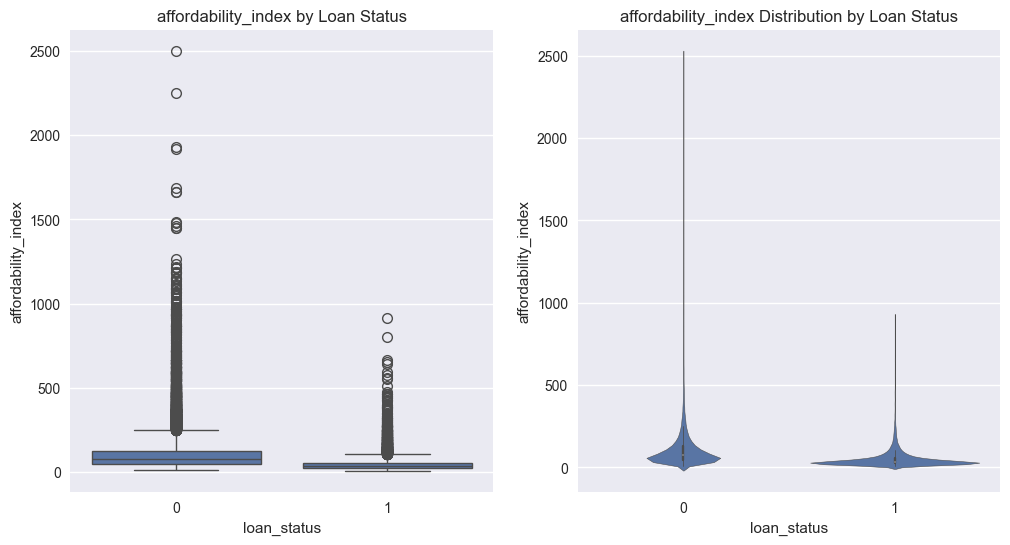

affordability_index: t=59.76, p=0.0000 (Welch's t-test)


In [8]:
def perform_eda(df):
    print("\nPerforming EDA...")
    
    # 1. Target variable analysis
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(x='loan_status', data=df)
    plt.title('Loan Status Distribution')
    
    plt.subplot(1, 2, 2)
    df['loan_status'].value_counts(normalize=True).plot.pie(autopct='%1.1f%%')
    plt.title('Loan Status Proportion')
    plt.show()
    
    # Statistical test for class imbalance
    n_default = df['loan_status'].sum()
    n_total = len(df)
    ci_low, ci_high = proportion_confint(n_default, n_total, method='wilson')
    print(f"\nDefault rate: {n_default/n_total:.2%} (95% CI: {ci_low:.2%}-{ci_high:.2%})")
    
    # 2. Numerical features analysis
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if len(num_cols) > 0:
        # Distribution plots with normality tests
        print("\nNumerical features analysis:")
        num_stats = pd.DataFrame(index=num_cols, columns=['Mean', 'Median', 'Skew', 'Kurtosis', 'Normality (p-value)'])
        
        for col in num_cols:
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            sns.histplot(df[col], kde=True)
            plt.title(f'{col} Distribution')
            
            plt.subplot(1, 2, 2)
            stats.probplot(df[col], plot=plt)
            plt.title(f'{col} Q-Q Plot')
            plt.show()
            
            # Calculate statistics
            num_stats.loc[col, 'Mean'] = df[col].mean()
            num_stats.loc[col, 'Median'] = df[col].median()
            num_stats.loc[col, 'Skew'] = df[col].skew()
            num_stats.loc[col, 'Kurtosis'] = df[col].kurtosis()
            
            # Shapiro-Wilk test for normality (only for smaller samples)
            if len(df) < 5000:
                _, p = stats.shapiro(df[col].dropna())
                num_stats.loc[col, 'Normality (p-value)'] = p
        
        display(num_stats)
        
        # Correlation analysis
        print("\nCorrelation matrix:")
        corr_matrix = df[num_cols].corr(method='pearson')
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f",
                   mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
        plt.title('Numerical Features Correlation')
        plt.show()
    
    # 3. Categorical features analysis
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(cat_cols) > 0:
        print("\nCategorical features analysis:")
        
        for col in cat_cols:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            sns.countplot(x=col, data=df, order=df[col].value_counts().index)
            plt.title(f'{col} Distribution')
            plt.xticks(rotation=45)
            
            plt.subplot(1, 2, 2)
            sns.barplot(x=col, y='loan_status', data=df,
                        order=df[col].value_counts().index)
            plt.title(f'Default Rate by {col}')
            plt.xticks(rotation=45)
            plt.show()
            
            # Chi-square test
            contingency_table = pd.crosstab(df[col], df['loan_status'])
            chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
            print(f"\n{col} vs. loan_status: Chi2={chi2:.2f}, p={p:.4f}, df={dof}")
    
    # 4. Target vs. features analysis
    print("\nTarget vs. features analysis:")
    for col in num_cols:
        if col != 'loan_status':
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            sns.boxplot(x='loan_status', y=col, data=df)
            plt.title(f'{col} by Loan Status')
            
            plt.subplot(1, 2, 2)
            sns.violinplot(x='loan_status', y=col, data=df)
            plt.title(f'{col} Distribution by Loan Status')
            plt.show()
            
            # T-test
            group1 = df[df['loan_status'] == 0][col].dropna()
            group2 = df[df['loan_status'] == 1][col].dropna()
            t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
            print(f"{col}: t={t_stat:.2f}, p={p_val:.4f} (Welch's t-test)")

# Perform EDA
perform_eda(df)



In [9]:
# Prepare data for modeling
X = df.drop('loan_status', axis=1)
y = df['loan_status']


In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   person_age                  32581 non-null  float64 
 1   person_income               32581 non-null  float64 
 2   person_home_ownership       32581 non-null  object  
 3   person_emp_length           32581 non-null  float64 
 4   loan_intent                 32581 non-null  object  
 5   loan_grade                  32581 non-null  object  
 6   loan_amnt                   32581 non-null  float64 
 7   loan_int_rate               32581 non-null  float64 
 8   loan_percent_income         32581 non-null  float64 
 9   cb_person_default_on_file   32581 non-null  int8    
 10  cb_person_cred_hist_length  32581 non-null  float64 
 11  debt_to_income              32581 non-null  float64 
 12  income_to_loan_ratio        32581 non-null  float64 
 13  interest_to_inco

## Model Feature Selection


Performing feature selection...

Univariate feature selection:


Feature      F_Score      F_p_value  MI_Score
10           interest_to_income  8466.663776   0.000000e+00  0.119154
14          loan_to_value_ratio  5714.294953   0.000000e+00  0.114120
8                debt_to_income  5714.294953   0.000000e+00  0.112870
5           loan_percent_income  5485.124289   0.000000e+00  0.083920
4                 loan_int_rate  3699.672523   0.000000e+00  0.070505
29                 loan_grade_D  3690.817927   0.000000e+00  0.039177
21   person_home_ownership_RENT  1963.713440   0.000000e+00  0.033788
13         low_income_high_debt  1795.270929   0.000000e+00  0.020637
1                 person_income  1758.969359   0.000000e+00  0.111796
15          affordability_index  1714.525376   0.000000e+00  0.121138
9          income_to_loan_ratio  1099.984181  2.974164e-237  0.119160
30                 loan_grade_E  1092.429190  1.153326e-235  0.012178
6     cb_person_default_on_file  1080.177944  4.353104e-233  0.011236
41           income_quantile_Q5   783.135431  2.604077e-170  0.014401
12         high_risk_age_income   658.714909  7.673548e-144  0.011764
3                     loan_amnt   367.039780   2.316241e-81  0.012863
20    person_home_ownership_OWN   342.244098   5.082273e-76  0.005463
31                 loan_grade_F   341.438426   7.580442e-76  0.004649
27                 loan_grade_B   279.261511   1.980625e-62  0.009364
40           income_quantile_Q4   253.960194   5.842799e-57  0.007671
2             person_emp_length   243.349542   1.154428e-54  0.004472
11      employment_to_age_ratio   240.154622   5.673486e-54  0.002641
32                 loan_grade_G   222.206849   4.368215e-50  0.003623
26          loan_intent_VENTURE   200.837273   1.872091e-45  0.004100
16             emp_length_score   186.724387   2.159483e-42  0.000000
18            simple_risk_score   147.832823   6.113201e-34  0.007293
24          loan_intent_MEDICAL   104.686259   1.558646e-24  0.006229
22        loan_intent_EDUCATION   100.107515   1.560968e-23  0.004475
39           income_quantile_Q3    61.277441   5.106773e-15  0.000000
23  loan_intent_HOMEIMPROVEMENT    43.716065   3.855020e-11  0.000000
33        age_cohort_Millennial    18.093598   2.108936e-05  0.000000
0                    person_age    16.236495   5.603353e-05  0.003519
25         loan_intent_PERSONAL    14.502711   1.402145e-04  0.003000
17            credit_hist_score    13.545851   2.331808e-04  0.004286
38           income_quantile_Q2    12.812126   3.448802e-04  0.000000
7    cb_person_cred_hist_length     9.030444   2.657219e-03  0.000386
28                 loan_grade_C     5.533266   1.866416e-02  0.000000
19  person_home_ownership_OTHER     5.126528   2.356935e-02  0.001764
34              age_cohort_GenX     2.179225   1.398946e-01  0.000114
35            age_cohort_Boomer     0.028327   8.663437e-01  0.000000
36            age_cohort_Silent          NaN            NaN  0.000565
37          age_cohort_Greatest          NaN            NaN  0.000065

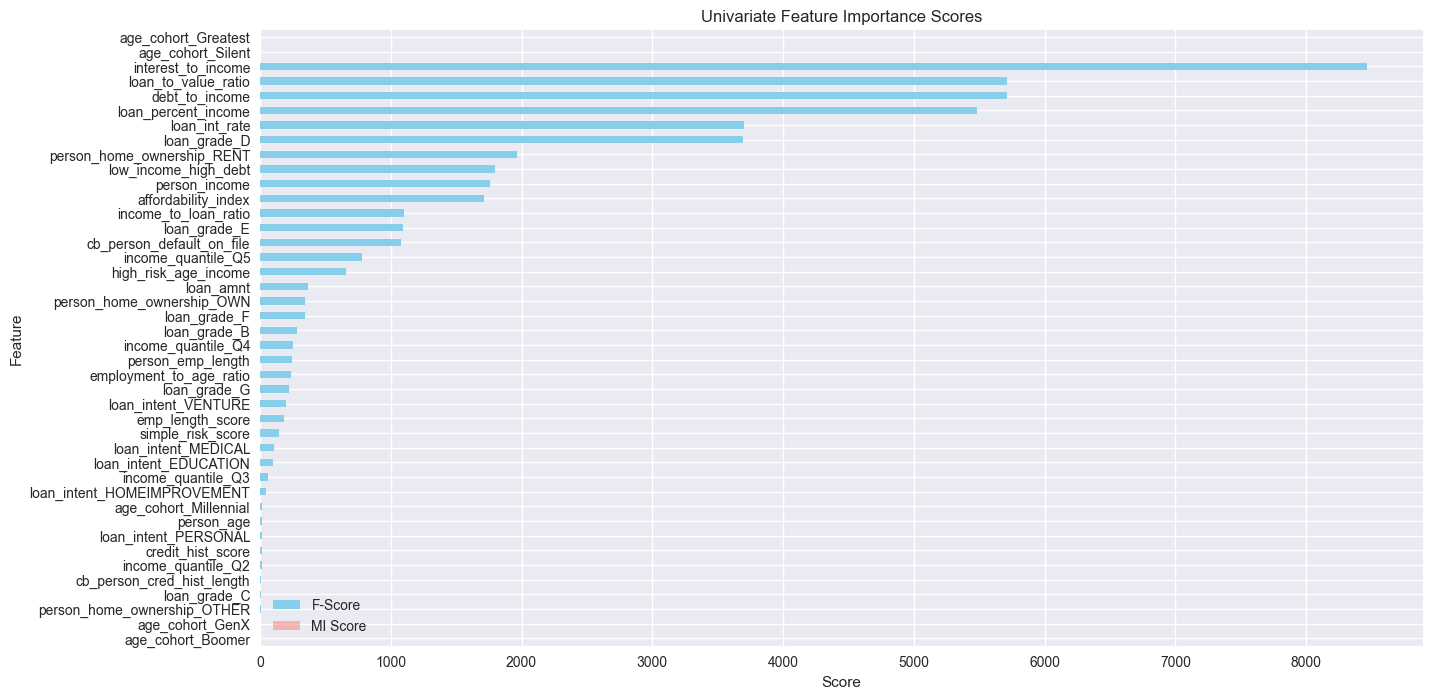


Recursive Feature Elimination with CV:
Optimal number of features: 30
Selected features:
Index(['loan_int_rate', 'loan_percent_income', 'debt_to_income',
       'income_to_loan_ratio', 'interest_to_income', 'employment_to_age_ratio',
       'high_risk_age_income', 'low_income_high_debt', 'loan_to_value_ratio',
       'emp_length_score', 'credit_hist_score', 'simple_risk_score',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E',
       'loan_grade_F', 'loan_grade_G', 'age_cohort_Boomer',
       'income_quantile_Q2', 'income_quantile_Q3', 'income_quantile_Q4',
       'income_quantile_Q5'],
      dtype='object')


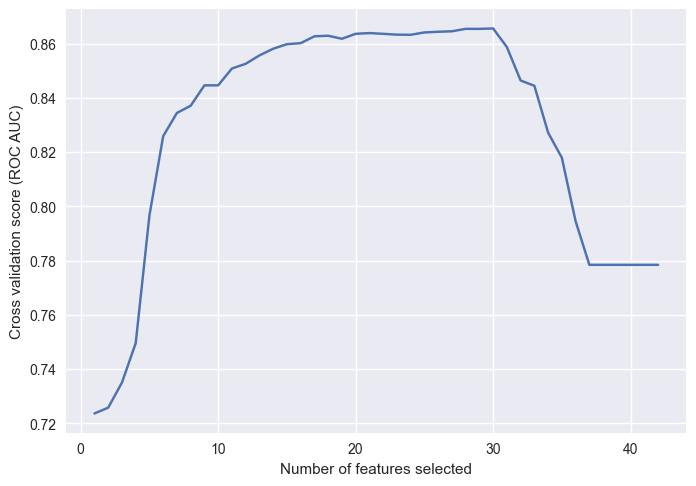


Feature importance from tree-based models:


Feature  RF_Importance  GB_Importance
8                debt_to_income       0.085739       0.044207
1                 person_income       0.081378       0.123069
4                 loan_int_rate       0.078266       0.128437
14          loan_to_value_ratio       0.078198       0.112994
21   person_home_ownership_RENT       0.077715       0.157412
10           interest_to_income       0.067047       0.050557
9          income_to_loan_ratio       0.065609       0.110696
15          affordability_index       0.059822       0.045441
29                 loan_grade_D       0.054838       0.094316
5           loan_percent_income       0.045871       0.001883
3                     loan_amnt       0.040674       0.000934
11      employment_to_age_ratio       0.037002       0.003304
2             person_emp_length       0.027055       0.017414
0                    person_age       0.024034       0.002286
20    person_home_ownership_OWN       0.017845       0.022361
7    cb_person_cred_hist_length       0.017659       0.000000
28                 loan_grade_C       0.012791       0.011053
24          loan_intent_MEDICAL       0.012774       0.012862
23  loan_intent_HOMEIMPROVEMENT       0.012445       0.013222
30                 loan_grade_E       0.011850       0.014519
22        loan_intent_EDUCATION       0.011270       0.007697
26          loan_intent_VENTURE       0.009628       0.007788
25         loan_intent_PERSONAL       0.008890       0.005121
6     cb_person_default_on_file       0.008614       0.000269
18            simple_risk_score       0.006555       0.000259
12         high_risk_age_income       0.004923       0.000100
16             emp_length_score       0.004421       0.000000
27                 loan_grade_B       0.004387       0.000031
33        age_cohort_Millennial       0.004264       0.000000
38           income_quantile_Q2       0.004049       0.000000
17            credit_hist_score       0.003780       0.000000
31                 loan_grade_F       0.003614       0.005289
39           income_quantile_Q3       0.003442       0.000000
40           income_quantile_Q4       0.003273       0.000000
41           income_quantile_Q5       0.003194       0.000000
13         low_income_high_debt       0.002131       0.000000
34              age_cohort_GenX       0.001876       0.000000
32                 loan_grade_G       0.001538       0.005498
35            age_cohort_Boomer       0.000832       0.000000
19  person_home_ownership_OTHER       0.000704       0.000982
36            age_cohort_Silent       0.000000       0.000000
37          age_cohort_Greatest       0.000000       0.000000

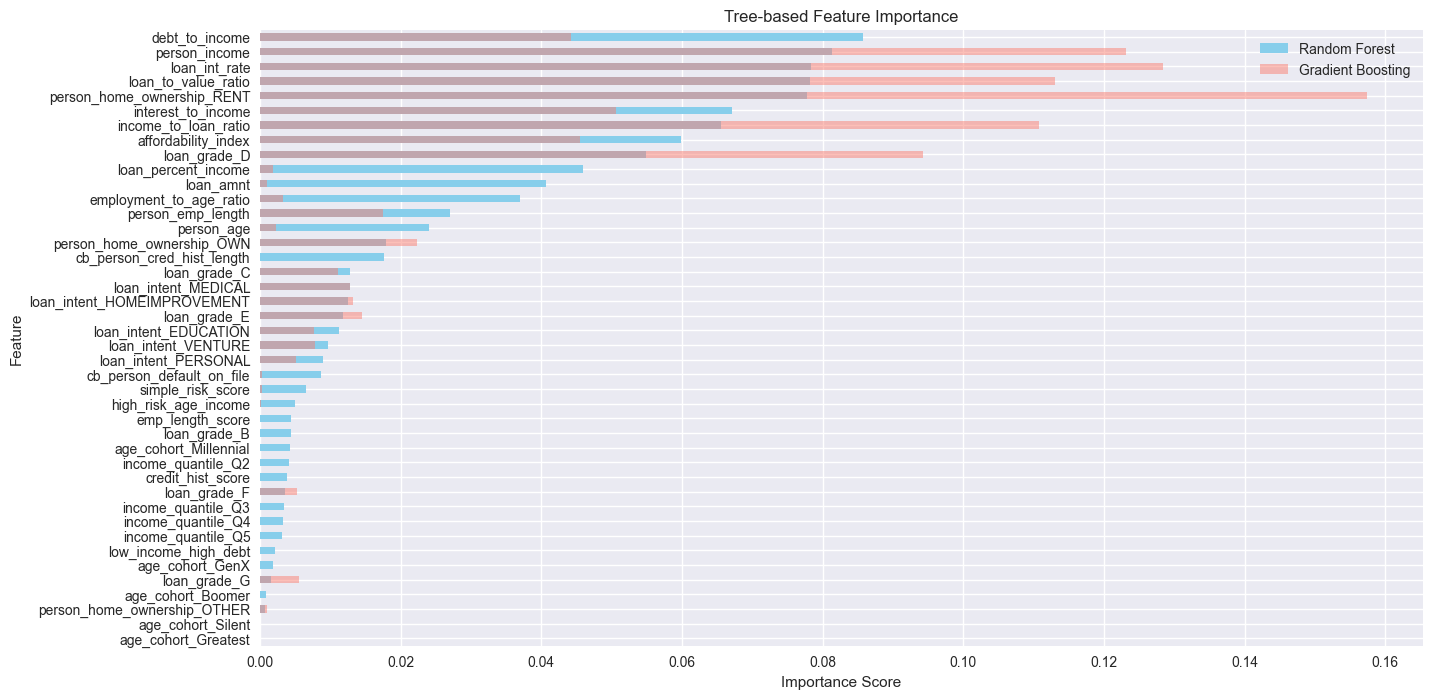


Multicollinearity analysis (VIF):


Feature          VIF
16             emp_length_score          inf
8                debt_to_income          inf
18            simple_risk_score          inf
17            credit_hist_score          inf
14          loan_to_value_ratio          inf
5           loan_percent_income  1086.374394
0                    person_age   127.933375
4                 loan_int_rate   121.274620
11      employment_to_age_ratio    73.023079
10           interest_to_income    61.966677
2             person_emp_length    60.750640
1                 person_income    30.427638
9          income_to_loan_ratio    30.332694
15          affordability_index    27.606248
3                     loan_amnt    23.250027
7    cb_person_cred_hist_length    21.549514
41           income_quantile_Q5    11.307407
34              age_cohort_GenX     6.347404
33        age_cohort_Millennial     5.725835
28                 loan_grade_C     5.508841
40           income_quantile_Q4     5.249314
29                 loan_grade_D     4.923836
27                 loan_grade_B     4.012809
39           income_quantile_Q3     3.646259
35            age_cohort_Boomer     3.635379
21   person_home_ownership_RENT     2.636240
30                 loan_grade_E     2.435727
38           income_quantile_Q2     2.417856
12         high_risk_age_income     2.407268
22        loan_intent_EDUCATION     2.238543
24          loan_intent_MEDICAL     2.187558
26          loan_intent_VENTURE     2.116915
25         loan_intent_PERSONAL     2.058395
6     cb_person_default_on_file     2.028571
23  loan_intent_HOMEIMPROVEMENT     1.717898
13         low_income_high_debt     1.625225
31                 loan_grade_F     1.467925
20    person_home_ownership_OWN     1.261858
32                 loan_grade_G     1.179836
19  person_home_ownership_OTHER     1.011313
36            age_cohort_Silent          NaN
37          age_cohort_Greatest          NaN


Final selected features for modeling:
['loan_int_rate', 'loan_percent_income', 'debt_to_income', 'income_to_loan_ratio', 'interest_to_income', 'employment_to_age_ratio', 'high_risk_age_income', 'low_income_high_debt', 'loan_to_value_ratio', 'emp_length_score', 'credit_hist_score', 'simple_risk_score', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F', 'loan_grade_G', 'age_cohort_Boomer', 'income_quantile_Q2', 'income_quantile_Q3', 'income_quantile_Q4', 'income_quantile_Q5']


In [11]:

def feature_selection(X, y, cv_splits=5):
   
    print("\nPerforming feature selection...")
    
    # 1. Univariate statistical tests
    print("\nUnivariate feature selection:")
    
    # ANOVA F-test
    f_test = SelectKBest(score_func=f_classif, k='all')
    f_test.fit(X, y)
    
    # Mutual information
    mi_test = SelectKBest(score_func=mutual_info_classif, k='all')
    mi_test.fit(X, y)
    
    # Create comparison dataframe
    univariate_results = pd.DataFrame({
        'Feature': X.columns,
        'F_Score': f_test.scores_,
        'F_p_value': f_test.pvalues_,
        'MI_Score': mi_test.scores_
    }).sort_values('F_Score', ascending=False)
    
    display(univariate_results)
    
    # Plot comparison
    plt.figure(figsize=(15, 8))
    univariate_results.set_index('Feature').sort_values('F_Score')['F_Score'].plot(
        kind='barh', color='skyblue', label='F-Score')
    univariate_results.set_index('Feature').sort_values('F_Score')['MI_Score'].plot(
        kind='barh', color='salmon', alpha=0.5, label='MI Score')
    plt.title('Univariate Feature Importance Scores')
    plt.xlabel('Score')
    plt.legend()
    plt.show()
    
    # 2. Recursive Feature Elimination with CV
    print("\nRecursive Feature Elimination with CV:")
    
    base_estimator = LogisticRegression(max_iter=1000, solver='liblinear')
    rfecv = RFECV(estimator=base_estimator, step=1, cv=StratifiedKFold(cv_splits),
                  scoring='roc_auc', n_jobs=-1)
    rfecv.fit(X, y)
    
    print(f"Optimal number of features: {rfecv.n_features_}")
    print("Selected features:")
    print(X.columns[rfecv.support_])
    
    # Plot number of features vs. CV scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (ROC AUC)")
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
    plt.show()
    
    # 3. Feature importance from ensemble methods
    print("\nFeature importance from tree-based models:")
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
    gb.fit(X, y)
    
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'RF_Importance': rf.feature_importances_,
        'GB_Importance': gb.feature_importances_
    }).sort_values('RF_Importance', ascending=False)
    
    display(importance_df)
    
    # Plot importance
    plt.figure(figsize=(15, 8))
    importance_df.set_index('Feature').sort_values('RF_Importance')['RF_Importance'].plot(
        kind='barh', color='skyblue', label='Random Forest')
    importance_df.set_index('Feature').sort_values('RF_Importance')['GB_Importance'].plot(
        kind='barh', color='salmon', alpha=0.5, label='Gradient Boosting')
    plt.title('Tree-based Feature Importance')
    plt.xlabel('Importance Score')
    plt.legend()
    plt.show()
    
    # 4. Multicollinearity analysis
    print("\nMulticollinearity analysis (VIF):")
     # Convert boolean columns to int
    X_numeric = X.copy()
    bool_cols = X_numeric.select_dtypes(include='bool').columns
    X_numeric[bool_cols] = X_numeric[bool_cols].astype(int)
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_numeric.columns
    vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(len(X_numeric.columns))]
    
    display(vif_data.sort_values('VIF', ascending=False))
    
    # Return comprehensive feature selection results
    feature_metrics = univariate_results.merge(importance_df, on='Feature')
    return feature_metrics, rfecv

# ---------------------
# Prepare data for modeling
# ---------------------

# Separate features and target
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Encode categorical variables in X
X = pd.get_dummies(X, drop_first=True)

# Encode y if it's categorical
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y)

# Perform feature selection
feature_metrics, rfecv = feature_selection(X, y)

# Select optimal features
selected_features = X.columns[rfecv.support_]
X_selected = X[selected_features]

# Output selected feature names
print("\nFinal selected features for modeling:")
print(list(selected_features))


## Model Fitting with RandomizedSearchCV

In [12]:
from sklearn.model_selection import RandomizedSearchCV
def build_advanced_models(X_train, y_train, cv_splits=3, n_iter=5):
    print("\nBuilding models with RandomizedSearchCV...")

    # 1. Preprocessing
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

    numeric_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler()),
        ('outlier', QuantileTransformer(output_distribution='normal'))
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

    # 2. Define models and reduced parameter spaces
    models = {
        'Logistic Regression': {
            'model': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
            'params': {
                'classifier__solver': ['liblinear', 'saga'],
                'classifier__penalty': ['l1', 'l2'],
                'classifier__C': np.logspace(-2, 2, 5)
            }
        },
        'Balanced Random Forest': {
            'model': BalancedRandomForestClassifier(random_state=42),
            'params': {
                'classifier__n_estimators': [100, 150],
                'classifier__max_depth': [None, 10],
                'classifier__min_samples_split': [2, 5]
            }
        },
        'XGBoost': {
            'model': xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
            'params': {
                'classifier__n_estimators': [100, 150],
                'classifier__max_depth': [3, 5],
                'classifier__learning_rate': [0.01, 0.1],
                'classifier__subsample': [0.8, 1.0]
            }
        }
            }

    best_models = {}
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    for name, config in models.items():
        print(f"\nTraining {name}...")
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', config['model'])
        ])

        random_search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=config['params'],
            n_iter=5,
            cv=cv,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1,
            random_state=42
        )

        random_search.fit(X_train, y_train)
        best_models[name] = random_search.best_estimator_

        print(f"Best parameters for {name}: {random_search.best_params_}")
        print(f"Best CV ROC AUC: {random_search.best_score_:.4f}")

    # 4. Build stacked model
    print("\nBuilding stacked model...")
    base_models = [
        ('lr', best_models['Logistic Regression']),
        ('xgb', best_models['XGBoost']),
        
    ]

    stacked_model = StackingClassifier(
        estimators=base_models,
        final_estimator=LogisticRegressionCV(cv=cv, max_iter=1000, random_state=42),
        stack_method='predict_proba',
        n_jobs=-1
    )

    stacked_model.fit(X_train, y_train)
    best_models['Stacked Model'] = stacked_model

    return best_models
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)
models = build_advanced_models(X_train, y_train)


Building models with RandomizedSearchCV...

Training Logistic Regression...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters for Logistic Regression: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l1', 'classifier__C': 1.0}
Best CV ROC AUC: 0.8177

Training Balanced Random Forest...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters for Balanced Random Forest: {'classifier__n_estimators': 150, 'classifier__min_samples_split': 2, 'classifier__max_depth': None}
Best CV ROC AUC: 0.8450

Training XGBoost...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters for XGBoost: {'classifier__subsample': 0.8, 'classifier__n_estimators': 150, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.1}
Best CV ROC AUC: 0.8469

Building stacked model...


## Model Evaluation


Evaluating models ...

Evaluating Logistic Regression...


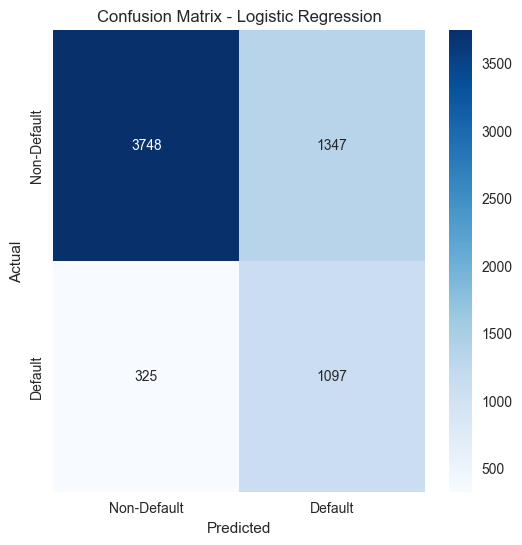

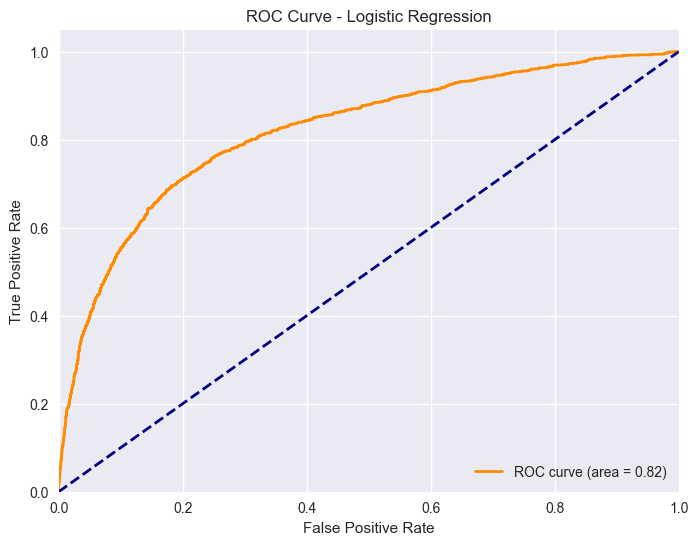


Classification Report - Logistic Regression:
              precision    recall  f1-score   support

 Non-Default       0.92      0.74      0.82      5095
     Default       0.45      0.77      0.57      1422

    accuracy                           0.74      6517
   macro avg       0.68      0.75      0.69      6517
weighted avg       0.82      0.74      0.76      6517


Evaluating Balanced Random Forest...


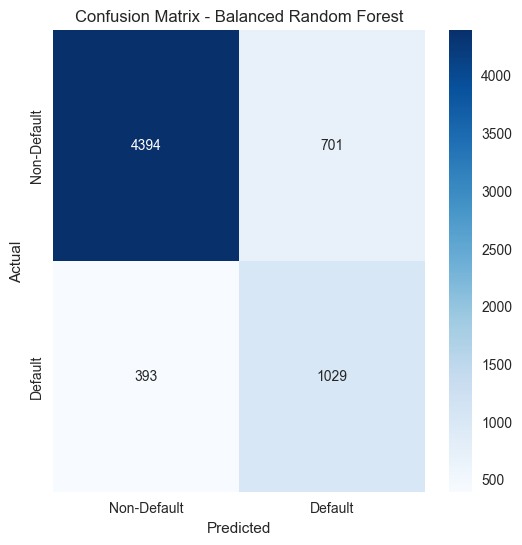

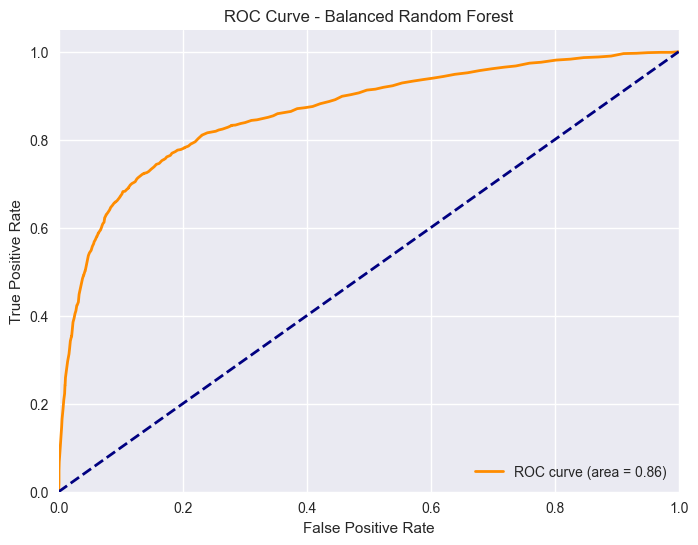


Classification Report - Balanced Random Forest:
              precision    recall  f1-score   support

 Non-Default       0.92      0.86      0.89      5095
     Default       0.59      0.72      0.65      1422

    accuracy                           0.83      6517
   macro avg       0.76      0.79      0.77      6517
weighted avg       0.85      0.83      0.84      6517


Evaluating XGBoost...


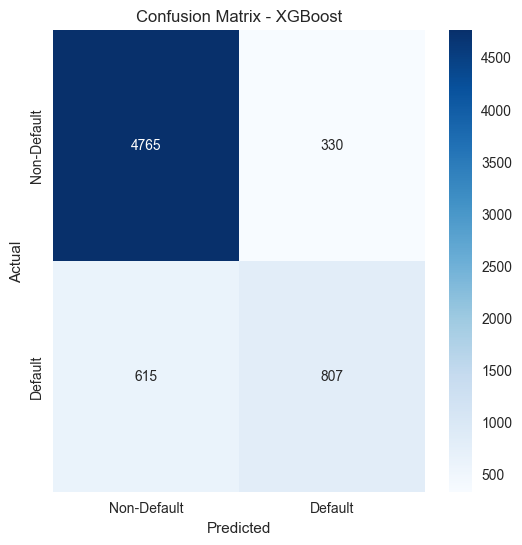

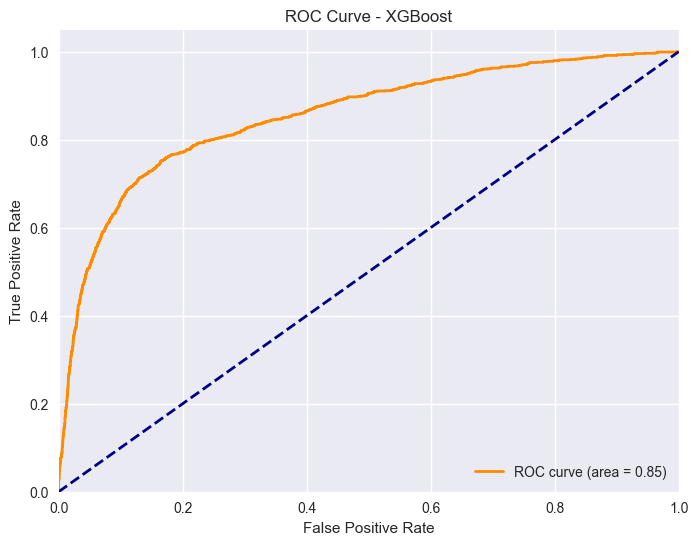


Classification Report - XGBoost:
              precision    recall  f1-score   support

 Non-Default       0.89      0.94      0.91      5095
     Default       0.71      0.57      0.63      1422

    accuracy                           0.85      6517
   macro avg       0.80      0.75      0.77      6517
weighted avg       0.85      0.85      0.85      6517


Evaluating Stacked Model...


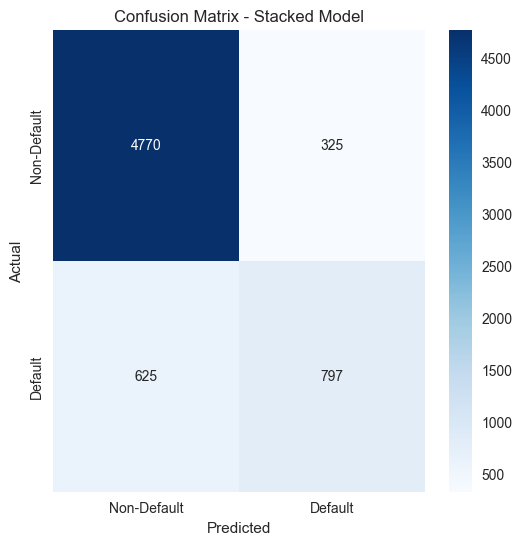

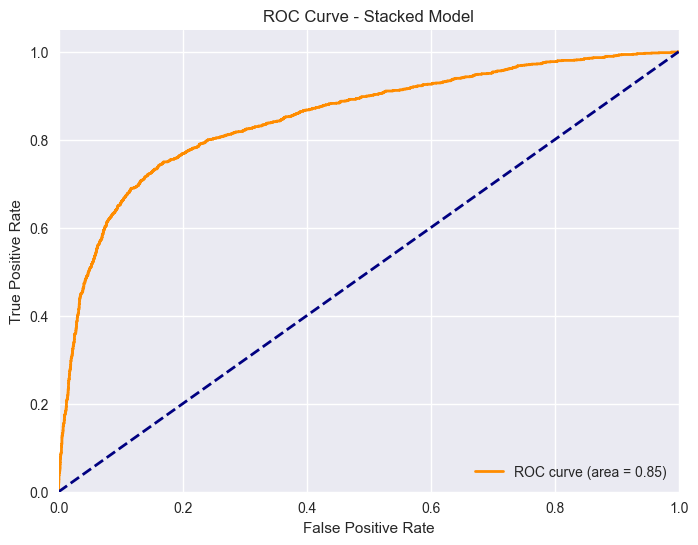


Classification Report - Stacked Model:
              precision    recall  f1-score   support

 Non-Default       0.88      0.94      0.91      5095
     Default       0.71      0.56      0.63      1422

    accuracy                           0.85      6517
   macro avg       0.80      0.75      0.77      6517
weighted avg       0.85      0.85      0.85      6517


Model Comparison:


CV ROC AUC     CV AP  CV Brier  Accuracy  Precision  \
Balanced Random Forest    0.850959  0.663802  0.130756  0.832131   0.594798   
XGBoost                   0.848916  0.660749  0.110642  0.854995   0.709763   
Stacked Model             0.846476  0.660781  0.111028  0.854227   0.710339   
Logistic Regression       0.817603  0.597386  0.174893  0.743440   0.448854   

                          Recall        F1   ROC AUC  Average Precision  \
Balanced Random Forest  0.723629  0.652919  0.861932           0.697696   
XGBoost                 0.567511  0.630715  0.853857           0.673027   
Stacked Model           0.560478  0.626572  0.850539           0.671062   
Logistic Regression     0.771449  0.567512  0.819939           0.604586   

                        Brier Score  
Balanced Random Forest     0.127810  
XGBoost                    0.108835  
Stacked Model              0.109825  
Logistic Regression        0.173673

In [13]:
def evaluate_advanced_models(models, X_train, y_train, X_test, y_test):
    print("\nEvaluating models ...")
    
    results = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, model in models.items():
        print(f"\nEvaluating {name}...")
        
        # Cross-validated metrics
        cv_preds = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
        cv_metrics = {
            'CV ROC AUC': roc_auc_score(y_train, cv_preds),
            'CV AP': average_precision_score(y_train, cv_preds),
            'CV Brier': brier_score_loss(y_train, cv_preds)
        }
        
        # Test set predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        metrics = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_pred_proba),
            'Average Precision': average_precision_score(y_test, y_pred_proba),
            'Brier Score': brier_score_loss(y_test, y_pred_proba)
        }
        
        results[name] = {**cv_metrics, **metrics}
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Non-Default', 'Default'],
                   yticklabels=['Non-Default', 'Default'])
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend(loc="lower right")
        plt.show()
        
        # Classification report
        print(f"\nClassification Report - {name}:")
        print(classification_report(y_test, y_pred, target_names=['Non-Default', 'Default']))
    
    # Compare models
    results_df = pd.DataFrame(results).T
    print("\nModel Comparison:")
    display(results_df.sort_values('ROC AUC', ascending=False))
    
    return results_df

# Evaluate models
results = evaluate_advanced_models(models, X_train, y_train, X_test, y_test)


### Interpretation
Balanced Random Forest has the highest recall (72%)—best for catching defaults but with more false alarms.

XGBoost leads in precision (71%) and accuracy (85%)—fewer false positives but misses more defaults.

Logistic Regression has worst precision (45%) but highest recall (77%)—poor balance.

XGBoost is best calibrated (lowest Brier Score), while Random Forest is best for AUC/recall.

### Conclusion:
Choose XGBoost if precision & reliability matter most (fewer false approvals). Pick Balanced Random Forest if catching defaults is critical (more false alarms). Tune thresholds or ensemble them for optimal trade-offs.

## Explainable Solution


Best model: Balanced Random Forest

Providing model explanations...

DALEX Explanations:
Preparation of a new explainer is initiated

  -> data              : 26064 rows 30 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 26064 values
  -> model_class       : imblearn.ensemble._forest.BalancedRandomForestClassifier (default)
  -> label             : Pipeline
  -> predict function  : <function yhat_proba_default at 0x0000017D70A5F9C0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 0.337, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.858, mean = -0.119, max = 0.453
  -> model_info        : package sklearn

A new explainer has been created!

Feature importance:


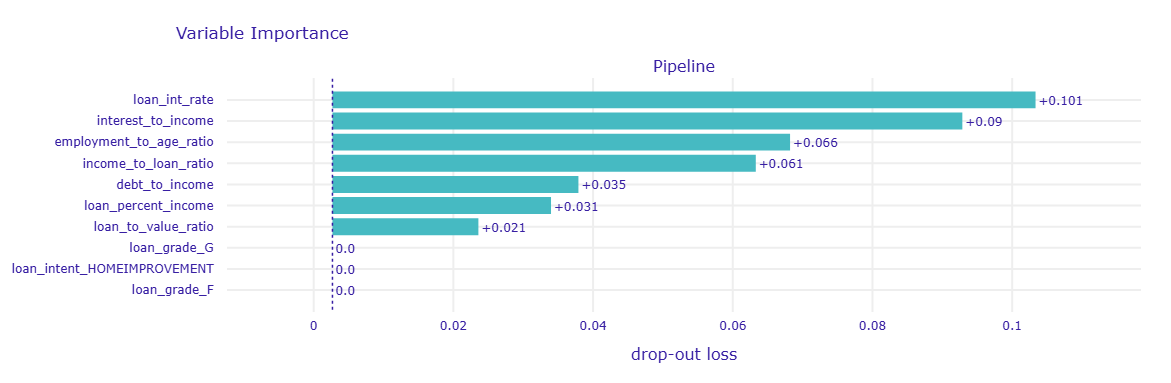


Partial dependence:


Calculating ceteris paribus: 100%|█████████████████████████████████████████████████████| 30/30 [00:51<00:00,  1.73s/it]



SHAP Values:


<Figure size 800x550 with 0 Axes>

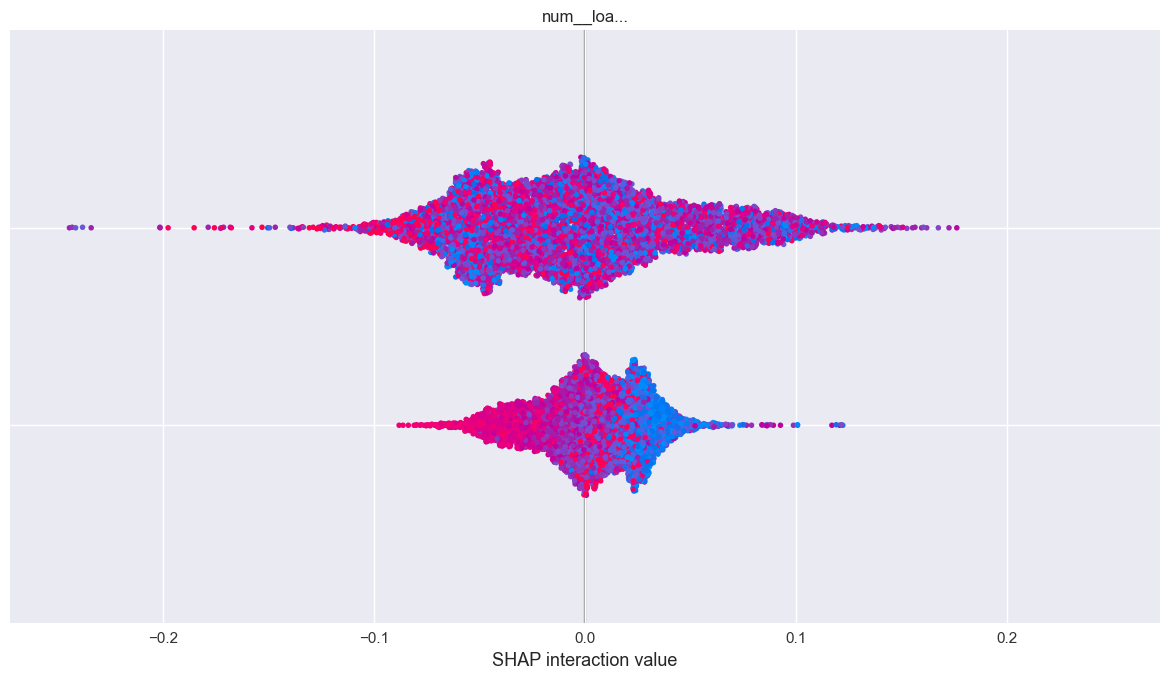

In [14]:
def explain_advanced_model(model, X_train, y_train, X_test, y_test, feature_names):
    
    print("\nProviding model explanations...")
    
    try:
        preprocessor = model.named_steps['preprocessor']
        classifier = model.named_steps['classifier']
    except:
        preprocessor = None
        classifier = model
    
    # 1. DALEX explainer
    print("\nDALEX Explanations:")
    try:
        dalex_exp = dx.Explainer(model, X_train, y_train, label=model.__class__.__name__)
        
        # Feature importance
        print("\nFeature importance:")
        fi = dalex_exp.model_parts()
        fi.plot()
        plt.show()
        
        # Partial dependence
        print("\nPartial dependence:")
        pdp = dalex_exp.model_profile()
        pdp.plot()
        plt.show()
    
    except Exception as e:
        print(f"DALEX explanation failed: {str(e)}")
    
    # 2. SHAP Values
    print("\nSHAP Values:")
    try:
        if preprocessor:
            X_train_transformed = preprocessor.transform(X_train)
            X_test_transformed = preprocessor.transform(X_test)
            
            if hasattr(preprocessor, 'get_feature_names_out'):
                transformed_feature_names = preprocessor.get_feature_names_out()
            else:
                numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
                categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
                numeric_feature_names = list(numeric_features)
                
                if 'onehot' in preprocessor.named_transformers_['cat'].named_steps:
                    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
                    categorical_feature_names = ohe.get_feature_names_out(categorical_features)
                else:
                    categorical_feature_names = list(categorical_features)
                
                transformed_feature_names = numeric_feature_names + list(categorical_feature_names)
        else:
            X_train_transformed = X_train.values
            X_test_transformed = X_test.values
            transformed_feature_names = feature_names
        
        if isinstance(classifier, (RandomForestClassifier, GradientBoostingClassifier, 
                                 xgb.XGBClassifier, lgb.LGBMClassifier)):
            explainer = shap.TreeExplainer(classifier)
        elif isinstance(classifier, LogisticRegression):
            explainer = shap.LinearExplainer(classifier, X_train_transformed)
        else:
            explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_train_transformed, 100))
        
        shap_values = explainer.shap_values(X_test_transformed)
        
        # Summary plot
        plt.figure()
        shap.summary_plot(shap_values, X_test_transformed, 
                         feature_names=transformed_feature_names,
                         class_names=['Non-Default', 'Default'],
                         plot_type='bar')
        plt.show()
        
    except Exception as e:
        print(f"SHAP explanation failed: {str(e)}")
# Explain best model
best_model_name = results['ROC AUC'].idxmax()
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name}")

explain_advanced_model(best_model, X_train, y_train, X_test, y_test, selected_features)
